## 세션 해석
- groupby 해서 최초 시간 기준으로 
- 뷰 -> 카트 -> 구매 구간별로 평균 걸리는 시간을 계산하는 방법은 좋았으나
- 같은 세션에서 여러가지 아이템을 구매하는 경우는 어떻게 해결해야 하는지 확인이 필요하다.

## 결측치 처리
- 어떤 노트에서는 drop 그냥 
- price 0인 데이터 의미 있을까?

funnel, cohort 분석 관련 참고 : https://brunch.co.kr/@neolee91/28

---

# 프로젝트 목표
## 대용량 데이터 핸들링
### 용량 축소
- csv : 5.27GB
- parquet변환 : 1.51GB
- 자료형 변환 : 0.92MB
- 추가 action : 불필요한 columns 제거/ 불필요한 범주형 자료 레이블화 등

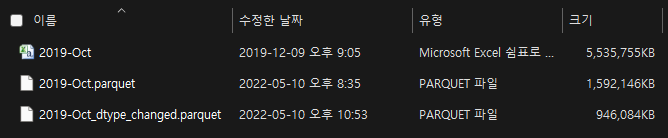

## 현황파악
### 로그데이터 - 유저의 행동이 나타나는 암묵적 피드백 
- funnel 분석
  - 어디가 취약점인지 찾기(이탈률이 어디가 가장 높은지, 전환율이 어디가 가장 낮은지)  
  1. 전체 대상
  2. 주별 대상
  3. 카테고리별(상위 top5 vs 하위 top5)

- cohort 분석
  - 주차별 비교
  - (advance) 다른 월 데이터 추가

- 세션
  - 세션별 머무는시간
  
## 매출 증대를 위한 Action Plan
- 인기있는 상품의 단가를 높인다
- 인기 없는 상품의 할인을 통해 구매율을 늘린다
- 이탈율을 줄일 수 있을 방법은 ?
- 인기있는 브랜드 제품의 유치를 늘린다.
- 인기없는 브랜드와 계약을 종료한다. 
  - 판매로 안이어져도 유입자체를 늘릴 수 있다면 의미가 있을 듯
- view 자체를 어떻게 늘릴지

## 어떤 추천 시스템을 적용해야할까
### 유저에게 어떻게 노출되는 것이 더 바람질할까?
- 관심있는 카테고리의 아이템을 더 노출시켜 줄 것인가?
- 장바구니에만 담고 구매로 이어지지 않는 제품을 계속 자극해서 구매로 이어지게 할 것인가?

---

# Import Library

In [1]:
# ! pip install plotly

# parquet 저장 및 로드 라이브러리 설치
# ! pip install pyarrow
# ! pip install sklearn

     |████████████████████████████████| 15.2 MB 21.5 MB/s eta 0:00:01
     |████████████████████████████████| 22.4 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 17.7 MB 577 kB/s eta 0:00:01
     |████████████████████████████████| 8.6 MB 893 kB/s eta 0:00:01
     |████████████████████████████████| 306 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 55.6 MB 589 kB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=6def66b76387af7e98b0f71d0bd58048f1db9e348b6c49bacdb97b385217ec5c
  Stored in directory: /Users/minky/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


# check point

In [1]:
#데이터셋 처리
import pandas as pd 
import numpy as np
import pyarrow.parquet as pq

#시각화
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc 
rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False 

#시간 데이터 처리
from datetime import datetime, timedelta

import warnings
warnings.simplefilter("ignore")

In [2]:
%%time
# parquet 변환된 데이터셋 로드: 10월
df_oct = pd.read_parquet('../e-commerce/input/2019-Oct_cleaned.parquet')

CPU times: user 13.8 s, sys: 10.7 s, total: 24.5 s
Wall time: 17.6 s


In [3]:
%%time
# parquet 변환된 데이터셋 로드: 11월
df_nov = pd.read_parquet('../e-commerce/input/2019-Nov_cleaned.parquet')

CPU times: user 20.3 s, sys: 13.9 s, total: 34.1 s
Wall time: 25.4 s


In [8]:
# 10월 데이터 
print(df_oct.shape)
df_oct.head()

(46701437, 14)


event_time event_type  product_id  \
0 2019-10-01 06:00:00       view    44600062   
1 2019-10-01 06:00:00       view     3900821   
2 2019-10-01 06:00:01       view    17200506   
3 2019-10-01 06:00:01       view     1307067   
4 2019-10-01 06:00:04       view     1004237   

                         category_code     brand        price    user_id  \
0                              unknown  shiseido    35.790001  541312140   
1  appliances.environment.water_heater      aqua    33.200001  554748717   
2           furniture.living_room.sofa   unknown   543.099976  519107250   
3                   computers.notebook    lenovo   251.740005  550050854   
4               electronics.smartphone     apple  1081.979980  535871217   

                           user_session event_date  event_month  event_day  \
0  72d76fde-8bb3-4e00-8c23-a032dfed738c 2019-10-01           10          1   
1  9333dfbd-b87a-4708-9857-6336556b0fcc 2019-10-01           10          1   
2  566511c2-e2e3-422b-b695-cf8e6e792ca8 2019-10-01           10          1   
3  7c90fc70-0e80-4590-96f3-13c02c18c713 2019-10-01           10          1   
4  c6bd7419-2748-4c56-95b4-8cec9ff8b80d 2019-10-01           10          1   

  day_of_week  event_hour  event_week  
0     Tuesday           6          40  
1     Tuesday           6          40  
2     Tuesday           6          40  
3     Tuesday           6          40  
4     Tuesday           6          40

In [7]:
# 11월 데이터 
print(df_nov.shape)
df_nov.head()

(62749880, 14)


event_time event_type  product_id       category_code    brand       price  \
0 2019-11-04       view    26405148             unknown  sokolov  696.799988   
1 2019-11-04       view    55000008     apparel.costume     nike  111.949997   
2 2019-11-04       view    35900057             unknown   apollo   10.270000   
3 2019-11-04       view     1201413  electronics.tablet  nexttab   47.860001   
4 2019-11-04       view    12705201             unknown  unknown   58.529999   

     user_id                          user_session event_date  event_month  \
0  386908545  657eee62-2b56-40ee-be6e-63bb05623727 2019-11-04           11   
1  530192239  2fb6b95e-3f82-4a44-966c-19c52954a977 2019-11-04           11   
2  567185457  c44929e6-88db-4b73-a3d9-dbab1602159b 2019-11-04           11   
3  546059044  bce815d4-0e5a-40f9-ba55-688fedec3b14 2019-11-04           11   
4  519027485  7f561f0e-3cef-4594-84c0-8e1383c0d872 2019-11-04           11   

   event_day day_of_week  event_hour  event_week  
0          4      Monday           0          45  
1          4      Monday           0          45  
2          4      Monday           0          45  
3          4      Monday           0          45  
4          4      Monday           0          45

In [45]:
print('10월 데이터 타입 확인: \n', df_oct.dtypes)
print('-'*30)
print('11월 데이터 타입 확인: \n', df_nov.dtypes)

10월 데이터 타입 확인: 
 event_time       datetime64[ns]
event_type             category
product_id                int32
category_code          category
brand                  category
price                   float32
user_id                   int32
user_session           category
event_date               object
event_day                 int32
day_of_week            category
event_hour                int32
event_week               UInt32
event_month               int32
dtype: object
------------------------------
11월 데이터 타입 확인: 
 event_time       datetime64[ns]
event_type             category
product_id                int32
category_code          category
brand                  category
price                   float32
user_id                   int32
user_session           category
event_date               object
event_day                 int32
day_of_week            category
event_hour                int32
event_week               UInt32
event_month               int32
dtype: object


## Price
#### Price=0인 데이터 제거하기

In [6]:
# price가 0 이하인 경우는 비정상적인 캐아스이고, 이런 데이터가 존재하는지 먼저 알아봄
print('10월 데이터 중 price가 0 이하인 데이터 수: ', df_oct[df_oct['price']<=0].price.count())
print('11월 데이터 중 price가 0 이하인 데이터 수: ', df_nov[df_nov['price']<=0].price.count())

10월 데이터 중 price가 0 이하인 데이터 수:  71372
11월 데이터 중 price가 0 이하인 데이터 수:  185307


In [5]:
# 데이터 제거하기
df_oct = df_oct[df_oct['price'] > 0]
df_nov = df_nov[df_nov['price'] > 0]

In [6]:
# 보험용으로 따로 보관해두기
raw_oct, raw_nov = df_oct.copy(), df_nov.copy()

---

# EDA

- `event_time`
  - UTC : 영국기준시(세계협정시)
  - 주별, 요일별, 시간대별 특성
  - (option) 비교군 추가 - 11월 데이터 and/or 그 이후
- `event_type`
  - view / cart / purchase
- `product_id`
- `brand`
- `price`
  - 단가가 높은 제품인지?
- `user_id`
  - 재구매 빈도 이런거 확인 가능할 듯 
_ `user_session`
  - 세션으로 어떤 가설 or 인사이트 찾을 수 있을 확인 필요

## 날짜별 방문 유저수 그래프 그리기
- 방문자수가 들쭉 날쭉 한다.
- 요일별로 방문자의 수가 차이난다고 생각해볼 수 있다. 

In [6]:
%%time
d_oct = df_oct[['event_date','user_id']]

# 중복제거 후 user_id 수 계산
visitor_by_date_oct = (d_oct.drop_duplicates().groupby(['event_date'])['user_id'].agg(['count']))

CPU times: user 8.3 s, sys: 3.4 s, total: 11.7 s
Wall time: 13.8 s


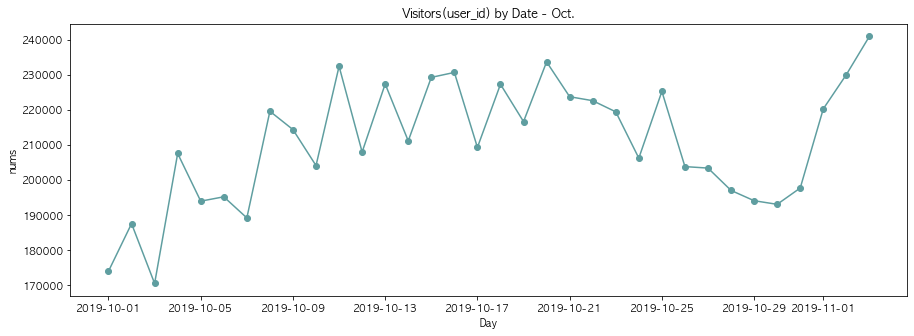

In [10]:
# x,y value 설정
x = visitor_by_date_oct.index
y = visitor_by_date_oct['count']

# 그래프 설정
plt.rcParams['figure.figsize'] = (15,5)
plt.plot(x, y, marker='o', color='#5F9EA0')

# 제목 및 축 설정
plt.title('Visitors(user_id) by Date - Oct.');
plt.xlabel('Day')
plt.ylabel('nums')

plt.show();

## 시간별 방문 유저수/구매 수 그래프 그리기

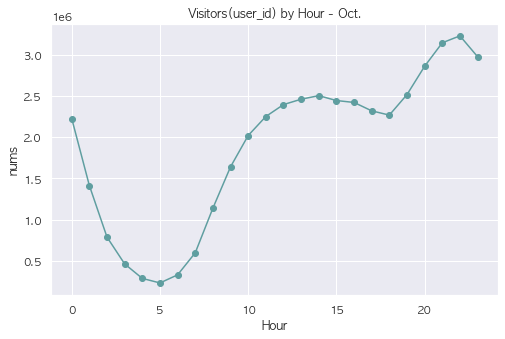

In [96]:
# 시간별 방문 유저 수 시각화하기

# x,y value 설정
hour_user =  df_oct[df_oct['event_type']=='view'].groupby(['event_hour']).user_id.count()
hour_user.sort_index(inplace=True)

y1 = hour_user
x1 = hour_user.index

# 그래프 설정
plt.rcParams['figure.figsize'] = (8,5)
plt.plot(x1, y1, marker='o', color='#5F9EA0')

# 제목 및 축 설정
plt.title('Visitors(user_id) by Hour - Oct.');
plt.xlabel('Hour')
plt.ylabel('nums')

plt.show();

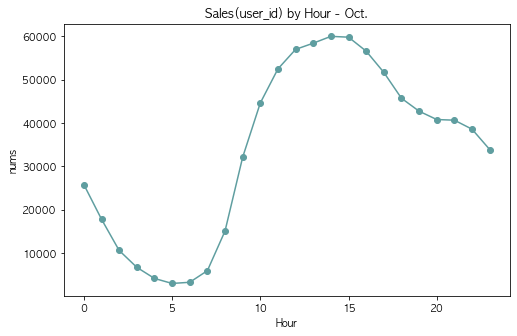

In [9]:
# 시간별 구매 수 시각화하기

# x,y value 설정
hour_sales =  df_oct[df_oct['event_type']=='purchase'].groupby(['event_hour']).user_id.count()
hour_sales.sort_index(inplace=True)

y = hour_sales
x = hour_sales.index

# 그래프 설정
plt.rcParams['figure.figsize'] = (8,5)
plt.plot(x, y, marker='o', color='#5F9EA0')

# 제목 및 축 설정
plt.title('Sales(user_id) by Hour - Oct.');
plt.xlabel('Hour')
plt.ylabel('nums')

plt.show();

#### 18~23시: view 수는 상승세, 구매 수는 하락세인 시간
##### view 수가 가장 많은 top 21 카테고리 및 브랜드

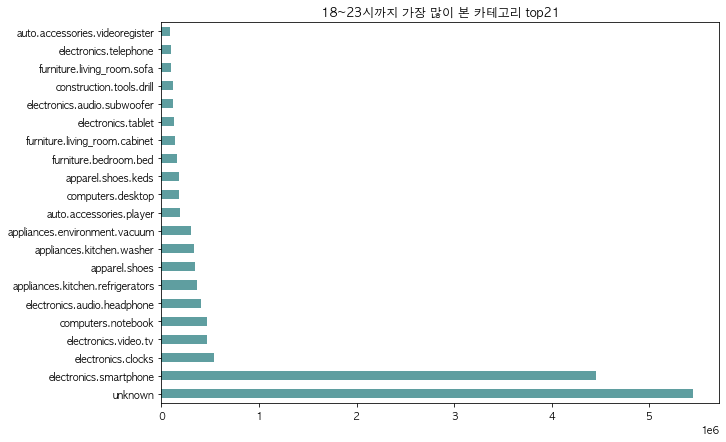

In [8]:
# 18시부터 23시까지 뷰잉 건수가 많은 상품
viewsp = df_oct[df_oct['event_type']=='view']
pro18 = viewsp[viewsp['event_hour']==18][['category_code', 'brand']]
pro19 = viewsp[viewsp['event_hour']==19][['category_code', 'brand']]
pro20 = viewsp[viewsp['event_hour']==20][['category_code', 'brand']]
pro21 = viewsp[viewsp['event_hour']==21][['category_code', 'brand']]
pro22 = viewsp[viewsp['event_hour']==22][['category_code', 'brand']]
pro23 = viewsp[viewsp['event_hour']==23][['category_code', 'brand']]

# 하나의 df로 병합하기
mostview = pd.concat([pro18, pro19, pro20, pro21, pro22, pro23])

# 18~23시에 가장 많이 뷰잉하는 제품군: 카테고리
mostview['category_code'].value_counts().nlargest(21).plot(kind='barh', color = '#5F9EA0')

# 제목 및 축 설정
plt.rcParams['figure.figsize'] = (10,7)
plt.title('18~23시까지 가장 많이 본 카테고리 top21');
plt.show();

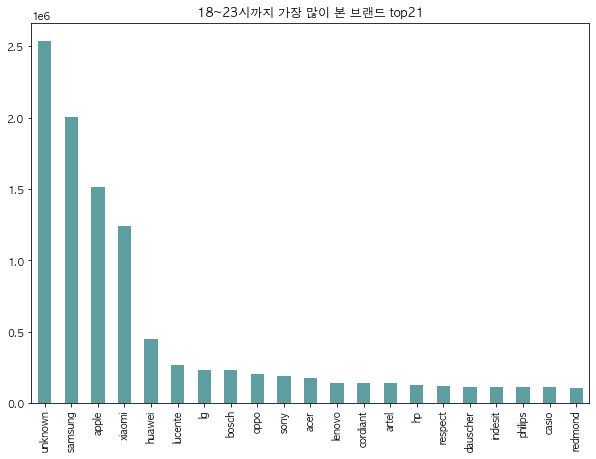

In [138]:
# 18~23시에 가장 많이 뷰잉하는 제품군: 브랜드
mostview['brand'].value_counts().nlargest(21).plot(kind='bar', color = '#5F9EA0')

# 제목 및 축 설정
plt.rcParams['figure.figsize'] = (10,7)
plt.title('18~23시까지 가장 많이 본 브랜드 top21');
plt.show();

## event_type

### event type에 따라 컬럼별 분포 살펴보기
- `event type == purchase`인 경우 

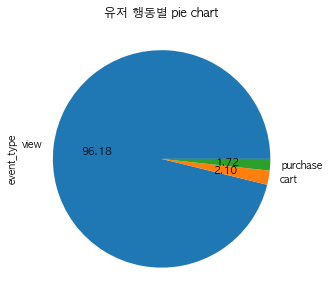

In [16]:
# event_type: 카테고리형 변수로, 각 값의 비중을 pie chart로 시각화
plt.figure(figsize = (5, 5))
df_oct['event_type'].value_counts().plot(kind='pie', autopct='%.2f')
plt.title('유저 행동별 pie chart');

- plotly 이용 funnel 그래프 그리기

In [17]:
#event_type 확인 
tmp = df_oct.groupby('event_type').size().sort_values(ascending=False)
tmp

event_type
view        45073281
cart          984090
purchase      808343
dtype: int64

In [22]:
# 아래 그래프 그리는데 오류가 떠서 설치
# pip install --upgrade nbformat

     |████████████████████████████████| 73 kB 3.2 MB/s eta 0:00:011
  Using cached fastjsonschema-2.15.3-py3-none-any.whl (22 kB)
     |████████████████████████████████| 72 kB 3.3 MB/s eta 0:00:011
  Using cached attrs-21.4.0-py2.py3-none-any.whl (60 kB)
     |████████████████████████████████| 81 kB 10.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
# 오프라인에서 plotly 그래프 띄우기
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode()

In [7]:
# funnel 그래프 생성
data = dict(number=tmp.values, stage=tmp.index)
fig = px.funnel(data, x='number', y='stage')
fig.update_layout(
    title={
        'text': "Funnel Graph - 이벤트 타입별",
        'y':0.95, 'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### event type에 따른 Category code / Brand / Price / Event_time 분포도
#### 1. `event_type == purchase`인 경우

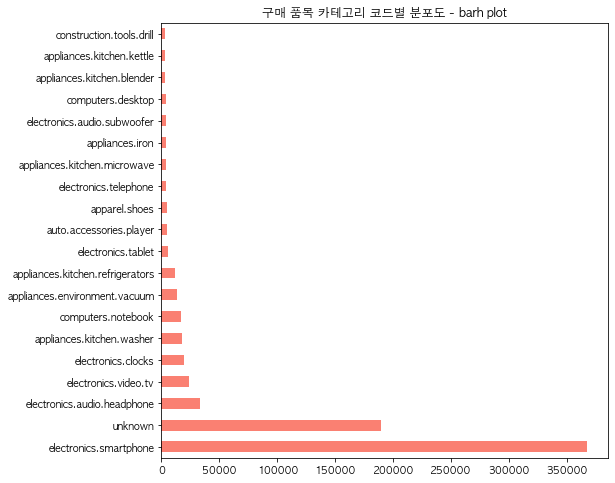

In [7]:
# 구매한 물품 중 가장 많은 비중을 차지하는 category_code
df_purchase = pd.DataFrame(df_oct[df_oct['event_type']=='purchase'])                # 구매한 경우의 데이터만 수집한 df_purchase 생성

# 위의 df에서 가장 많이 분포되어 있는 category code top 20은 어떤 것들인지 barh plot으로 나타내봄
df_purchase['category_code'].value_counts().nlargest(20).plot(kind='barh', figsize=(8,8), color='#FA8072')
plt.title('구매 품목 카테고리 코드별 분포도 - barh plot');

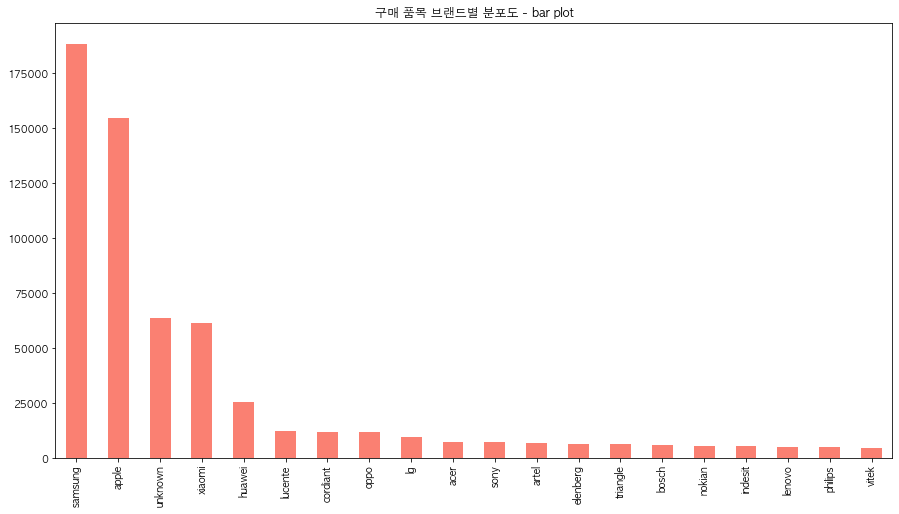

In [18]:
# 위의 그래프와 마찬가지로 top 20의 브랜드에는 어떤 것들이 있는지 bar plot으로 확인해봄
df_purchase['brand'].value_counts().nlargest(20).plot(kind='bar', figsize=(15,8), color='#FA8072')
plt.title('구매 품목 브랜드별 분포도 - bar plot');

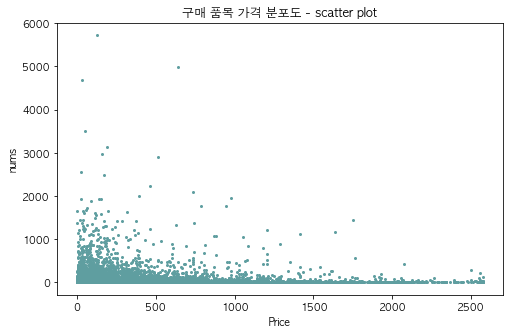

In [17]:
# df_purchase에서 price의 분포를 살펴보기 위해 scatter plot을 사용
plt.figure(figsize=(8, 5))
plt.scatter(df_purchase['price'].unique(), df_purchase['price'].value_counts(), s = 4, color='#5F9EA0')
plt.xlabel('Price')
plt.ylabel('nums')
plt.title('구매 품목 가격 분포도 - scatter plot');

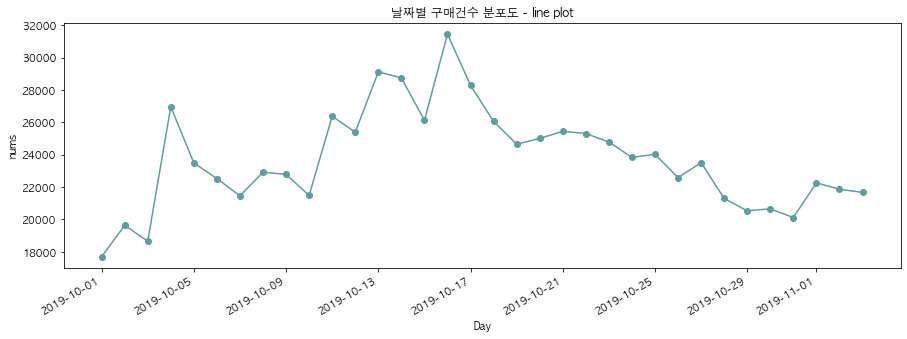

In [14]:
# 날짜별로 구매한 케이스의 분포도를 line plot으로 살펴보기
# Line plot으로 살펴보기
df_purchase['event_date'].value_counts().plot(kind = 'line', marker='o', figsize=(15,5), color='#5F9EA0')
plt.xlabel('Day')
plt.ylabel('nums')
plt.title('날짜별 구매건수 분포도 - line plot');

#### 2. `event type == cart`인 경우

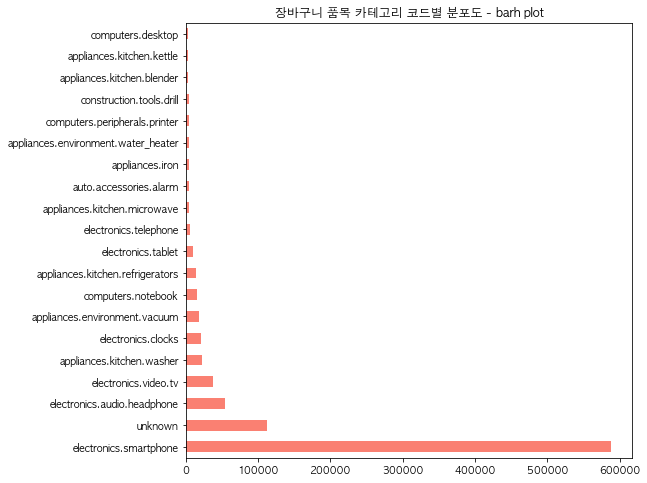

In [8]:
# 장바구니 담은 물품 중 가장 많은 비중을 차지하는 category_code
df_cart = pd.DataFrame(df_oct[df_oct['event_type']=='cart'])   

# 위의 df에서 가장 많이 분포되어 있는 category code top 20은 어떤 것들인지 barh plot으로 나타내봄 = 주로 어떤 품목을 장바구니에 담는지 확인하기
df_cart['category_code'].value_counts().nlargest(20).plot(kind='barh', figsize=(8,8), color='#FA8072')
plt.title('장바구니 품목 카테고리 코드별 분포도 - barh plot');

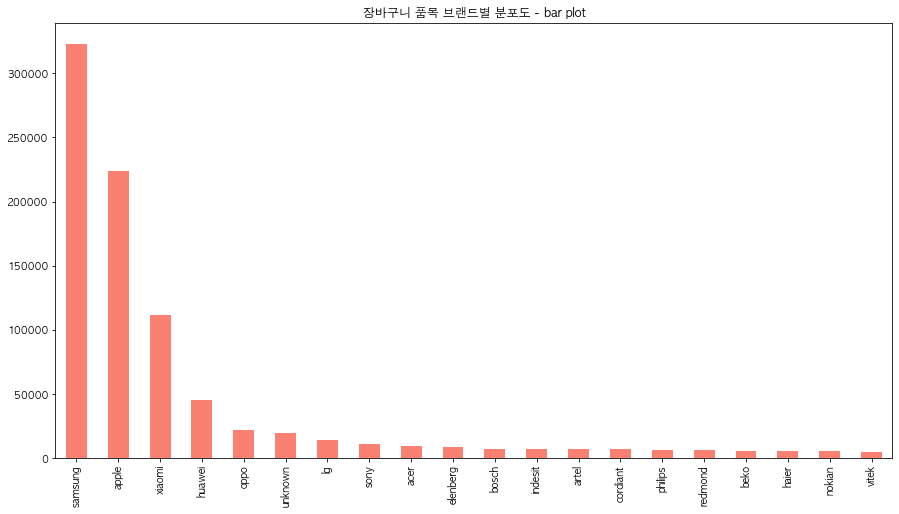

In [16]:
# event_type = 'cart'일 때 top 20 브랜드를 bar plot으로 확인
df_cart['brand'].value_counts().nlargest(20).plot(kind='bar', figsize=(15,8), color='#FA8072')
plt.title('장바구니 품목 브랜드별 분포도 - bar plot');

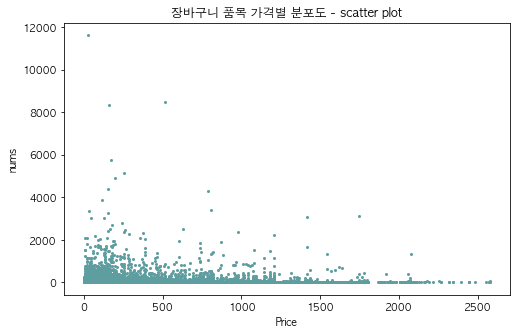

In [19]:
# df_cart에서 price의 분포를 살펴보기 위해 scatter plot을 사용
plt.figure(figsize=(8, 5))
plt.scatter(df_cart['price'].unique(), df_cart['price'].value_counts(), s = 4, color='#5F9EA0')
plt.xlabel('Price')
plt.ylabel('nums')
plt.title('장바구니 품목 가격별 분포도 - scatter plot');

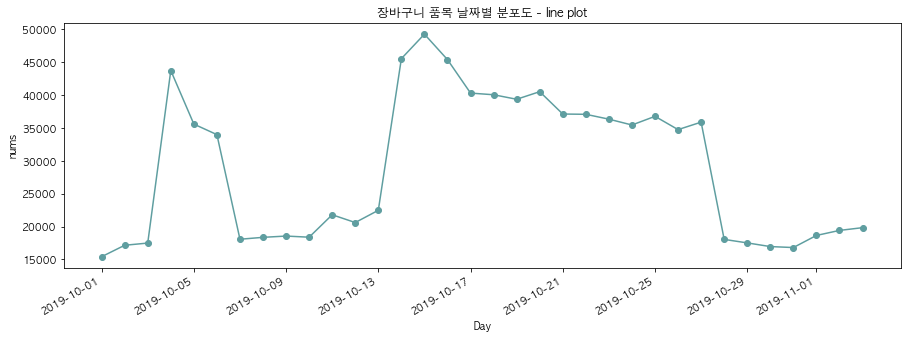

In [20]:
# 날짜별로 구매한 케이스의 분포도를 line plot으로 살펴보기
# Line plot으로 살펴보기
df_cart['event_date'].value_counts().plot(kind = 'line', marker='o', figsize=(15,5), color='#5F9EA0')
plt.xlabel('Day')
plt.ylabel('nums')
plt.title('장바구니 품목 날짜별 분포도 - line plot');

#### 3. `event type == view`인 경우

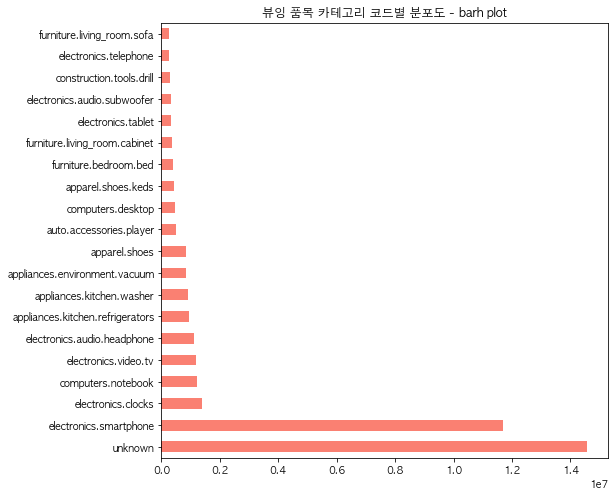

In [9]:
# 뷰잉한 물품 중 가장 많은 비중을 차지하는 category_code
df_view = pd.DataFrame(df_oct[df_oct['event_type']=='view'])                # 뷰잉한 경우의 데이터만 수집한 df_purchase 생성

# 위의 df에서 가장 많이 분포되어 있는 category code top 20은 어떤 것들인지 barh plot으로 나타내봄
df_view['category_code'].value_counts().nlargest(20).plot(kind='barh', figsize=(8,8), color='#FA8072')
plt.title('뷰잉 품목 카테고리 코드별 분포도 - barh plot');

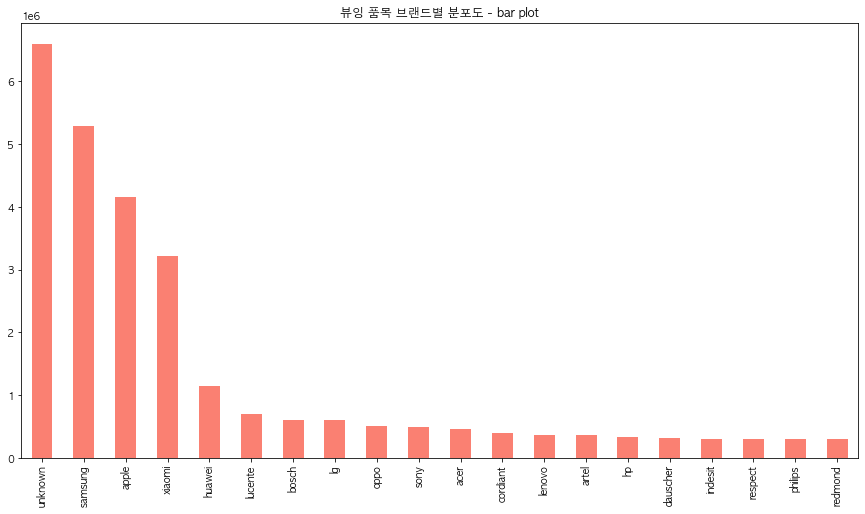

In [22]:
# event_type = 'view'일 때 top 20 브랜드를 bar plot으로 확인
df_view['brand'].value_counts().nlargest(20).plot(kind='bar', figsize=(15,8), color='#FA8072')
plt.title('뷰잉 품목 브랜드별 분포도 - bar plot');

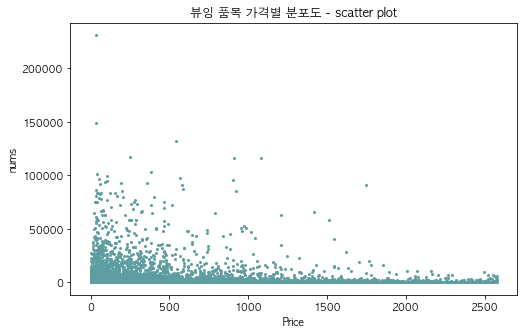

In [23]:
# df_view에서 price의 분포를 살펴보기 위해 scatter plot을 사용
plt.figure(figsize=(8, 5))
plt.scatter(df_view['price'].unique(), df_view['price'].value_counts(), s = 4, color='#5F9EA0')
plt.xlabel('Price')
plt.ylabel('nums')
plt.title('뷰잉 품목 가격별 분포도 - scatter plot');

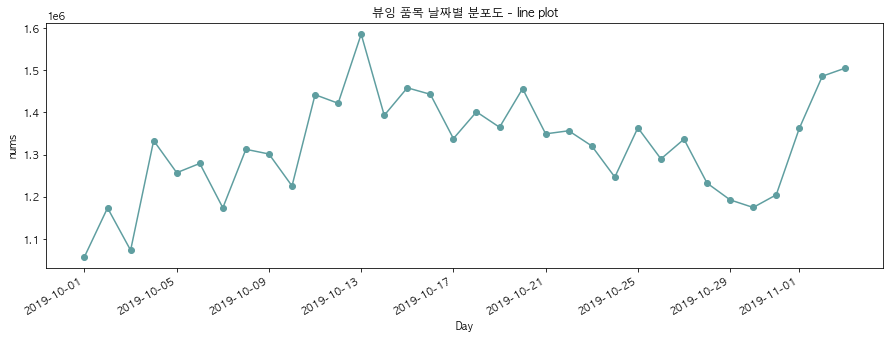

In [24]:
# 날짜별로 구매한 케이스의 분포도를 line plot으로 살펴보기
# Line plot으로 살펴보기
df_view['event_date'].value_counts().plot(kind = 'line', marker='o', figsize=(15,5), color='#5F9EA0')
plt.xlabel('Day')
plt.ylabel('nums')
plt.title('뷰잉 품목 날짜별 분포도 - line plot');

-------

## 변수 간 상관관계 파악
- heatmap 사용

In [78]:
from sklearn.preprocessing import LabelEncoder

# df_oct 복사하기
dflabel = df_oct.copy()

le = LabelEncoder()
columns = ['event_type', 'brand', 'category_code', 'day_of_week', 'user_session', 'event_date']
dflabel[columns]=dflabel[columns].apply(lambda x : le.fit_transform(x))

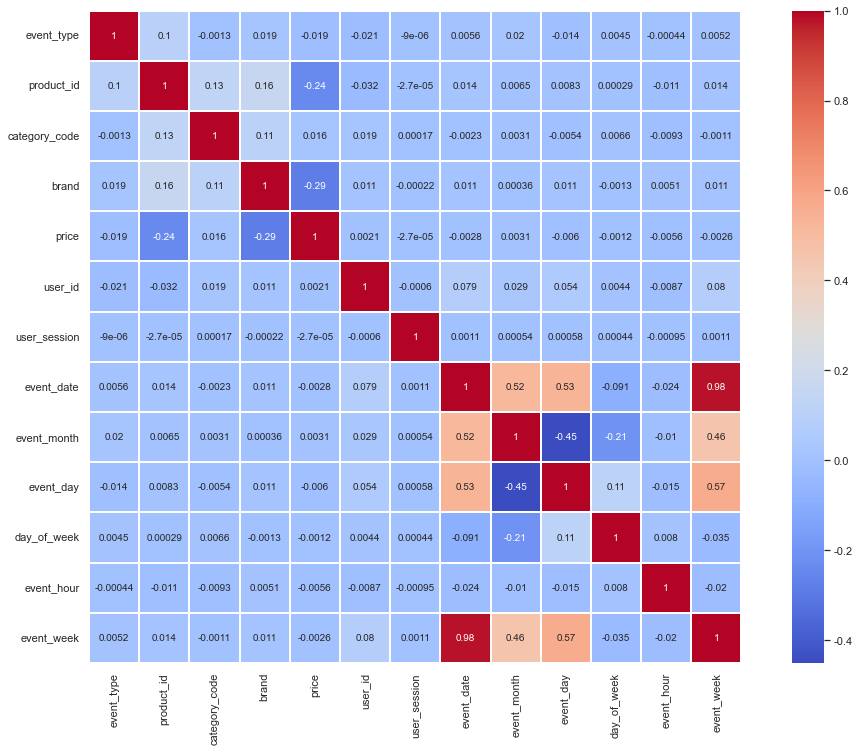

In [79]:
# Event time 빼고 heatmap 도출해보기
dflabel.drop(['event_time'], axis=1, inplace=True)

# dflabel 대한 heat map: 변수들 간의 상관관계 파악
sns.set(rc = {'figure.figsize':(18,12)})
sns.heatmap(dflabel.corr(), linewidths = 0.1, vmax = 1.0, cmap='coolwarm', square = True, linecolor = "white", annot = True, annot_kws = {"size" : 10});

-------------------------
# 가설 설정
#### 1. 주말/주중 중 주말의 구매 전환율은 차이가 날 것이다.
        - 아랍국가 중 UAE는 2019년 당시 주말이 금/토
#### 2. 사이트에 오래 머물수록 구매 전환율이 더 높을 것이다.
#### 3. brand가 있는 상품일 경우의 평균 구매 전환율이 없는 상품일 경우보다 더 높을 것이다.
#### 4. categorized가 잘 되어 있지 않은 상품의 View 수는 잘 되어 있는 상품보다 더 적을 것이다. 

# 가설 검정

## 👇🏼 가설 1
### 1. 요일과 유저 행동 간 연관성
- 카이제곱검정

In [19]:
# 요일과 유저 행동 간 간의 카이제곱검정
from scipy.stats import chi2_contingency

chi_res1 = chi2_contingency(pd.crosstab(df10['day_of_week'], df10['event_type']))
print('요일과 유저 행동 간의 Chi2 Statistic: {}, p-value: {}'.format(chi_res1[0], chi_res1[1]))

요일과 유저 행동 간의 Chi2 Statistic: 2518.522578457495, p-value: 0.0


### **🔍 정리**
- pvalue = 0.0 이므로 요일과 유저 행동 간의 연관성이 있다고 볼 수 있음

### 2. **요일별 구매 전환율** 구하기

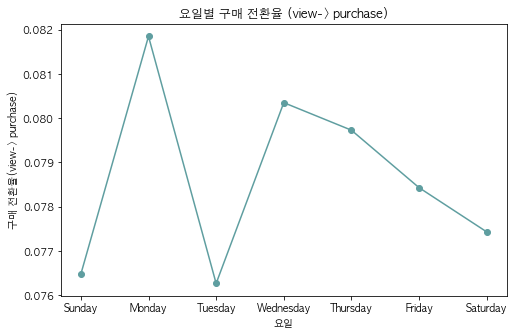

In [63]:
# 요일별 전환율 구하기(view -> purchase)
day_visit = df_oct.groupby(['day_of_week']).user_session.nunique()      # 요일별 방문 수
day_purchase = df_oct[df_oct['event_type']=='purchase'].groupby(['day_of_week']).event_type.count()

day_conversion_vp = pd.DataFrame(day_purchase/day_visit)        # 전환율 구하기

weekday_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
day_conversion_vp = day_conversion_vp.loc[weekday_order]        # 일~토 순으로 요일 재정렬


# 요일별 구매전환율 시각화하기(view -> purchase)
x = day_conversion_vp.index
y = day_conversion_vp[0]

# 그래프 설정
plt.rcParams['figure.figsize'] = (8,5)
plt.plot(x, y, marker='o', color='#5F9EA0')

# 제목 및 축 설정
plt.title('요일별 구매 전환율 (view-> purchase)');
plt.xlabel('요일')
plt.ylabel('구매 전환율(view-> purchase)')

plt.show();

#### 3. **각 주차의** 요일별 구매전환율 시각화

In [12]:
# 구매전환율(뷰잉 -> 구매) 구하기
daily_visits = df_oct.groupby(['event_date']).user_session.nunique()         # 접속 수 구하는 건 기존의 했던 코드로 진행하기

# 날짜별 구매 수 구하기
daily_sales = df_purchase.groupby(['event_date']).event_type.count()

# 날짜별 구매전환율(view -> purchase) 구하기
daily_purchase_conversion_vp = daily_sales/daily_visits

df_daily_conversion = pd.DataFrame(daily_purchase_conversion_vp)     # 일별 전환율 담은 Df 만들기 (view -> purchase)

# 날짜/요일별 전환율 담은 Df 만들기 (view -> purchase)
df_daily_conversion.reset_index(inplace=True)        # 인덱스 리셋
df_daily_conversion.rename(columns = {0 : 'conversion_viewpurchase'}, inplace = True)    # 컬럼 이름 변경
df_daily_conversion['day_of_week'] = df_daily_conversion['event_date'].dt.day_name()  # 요일 컬럼 추가
df_daily_conversion.head(5)

event_date  conversion_viewpurchase day_of_week
0 2019-10-01                 0.072752     Tuesday
1 2019-10-02                 0.073955   Wednesday
2 2019-10-03                 0.077623    Thursday
3 2019-10-04                 0.090409      Friday
4 2019-10-05                 0.085129    Saturday

In [121]:
# 요일별 구매 전환율의 요약통계량 도출하기
df_daily_conversion.groupby('day_of_week').describe()

conversion_viewpurchase                                          \
                              count      mean       std       min       25%   
day_of_week                                                                   
Friday                          5.0  0.078556  0.007420  0.070388  0.074957   
Monday                          4.0  0.081642  0.007369  0.074935  0.078080   
Saturday                        5.0  0.077780  0.007676  0.065660  0.077207   
Sunday                          5.0  0.076821  0.009289  0.062807  0.072843   
Thursday                        5.0  0.079455  0.008441  0.071714  0.073608   
Tuesday                         5.0  0.075994  0.003118  0.072752  0.073859   
Wednesday                       5.0  0.079804  0.008955  0.073955  0.074635   

                                           
                  50%       75%       max  
day_of_week                                
Friday       0.078296  0.078730  0.090409  
Monday       0.079752  0.083315  0.092131  
Saturday     0.077273  0.083629  0.085129  
Sunday       0.080192  0.081423  0.086839  
Thursday     0.077623  0.081304  0.093024  
Tuesday      0.074892  0.078328  0.080137  
Wednesday    0.075568  0.079506  0.095355

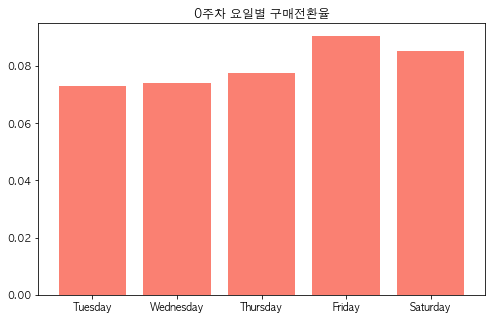

In [125]:
# 각 주차별로 주중/주말의 일별 구매전환율의 시각화 (view -> purchase)
# week 0: 10/1 ~ 10/5
week0 = df_daily_conversion[(df_daily_conversion['event_date'] < '2019-10-06')]

plt.figure(figsize = (8, 5))
plt.bar(week0['day_of_week'], week0['conversion_viewpurchase'], color='#FA8072')
plt.title('0주차 요일별 구매전환율');

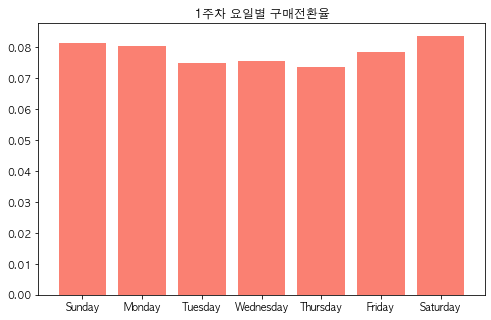

In [126]:
# week1 2: 10/6 ~ 10/12 (view -> purchase)
week1 = df_daily_conversion[('2019-10-05' < df_daily_conversion['event_date'] ) & 
(df_daily_conversion['event_date'] < '2019-10-13')]

plt.figure(figsize = (8, 5))
plt.bar(week1['day_of_week'], week1['conversion_viewpurchase'], color='#FA8072')
plt.title('1주차 요일별 구매전환율');

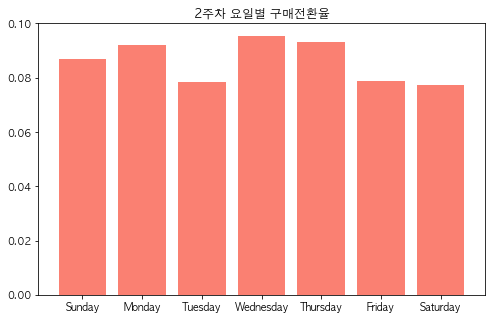

In [127]:
# week 2: 10/13 ~ 10/19 (view -> purchase)
week2 = df_daily_conversion[('2019-10-12' < df_daily_conversion['event_date'] ) & 
(df_daily_conversion['event_date'] < '2019-10-20')]

plt.figure(figsize = (8, 5))
plt.bar(week2['day_of_week'], week2['conversion_viewpurchase'], color='#FA8072')
plt.title('2주차 요일별 구매전환율');

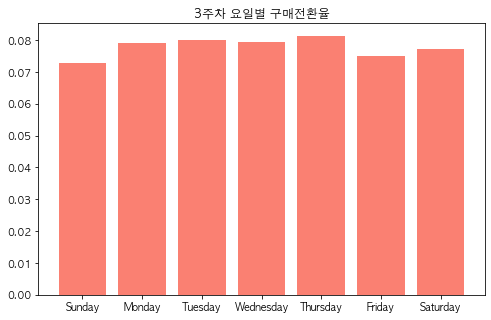

In [129]:
# week 3: 10/20 ~ 10/26 (view -> purchase)
week3 = df_daily_conversion[('2019-10-19' < df_daily_conversion['event_date'] ) & 
(df_daily_conversion['event_date'] < '2019-10-27')]

plt.figure(figsize = (8, 5))
plt.bar(week3['day_of_week'], week3['conversion_viewpurchase'], color='#FA8072')
plt.title('3주차 요일별 구매전환율');

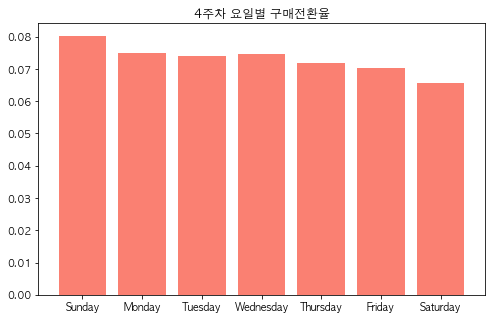

In [130]:
# week 4: 10/27 ~ 11/1 (view -> purchase)
week4 = df_daily_conversion[('2019-10-26' < df_daily_conversion['event_date'])]

plt.figure(figsize = (8, 5))
plt.bar(week4['day_of_week'], week4['conversion_viewpurchase'], color='#FA8072')
plt.title('4주차 요일별 구매전환율');

### 🔍 주차별 요일 구매전환율 그래프 정리

        - 0주차: 금/토 구매 전환율이 가장 높음
        - 1주차: 일월금토 전환율이 높고, 화수목 전환율은 낮은편 + 토요일이 가장 높음
        - 2주차: 수목월일 순으로 높음, 화금토는 상대적으로 꽤 낮음
        - 3주차: 가장 모든 요일이 일정한 편, 육안으로는 목요일이 가장 높은 것으로 보이고 일요일이 가장 낮음
        - 4주차: 일요일 가장 높고 월화수목은 비슷, 금토 차이나게 낮음

#### **👉🏼 총정리: 0~1주차에는 화수목에 구매전환율이 낮으나, 2~4주차에는 일요일을 비롯한 주중의 전환율이 높은 편**

------
### 📌 t-test 검정: 주말/주중 평균 구매전환율 같은지 검정

In [14]:
# T-test 실시하기: conversion = view => purchase 일 떄
# 먼저 주중/주말 구분하도록 df 생성

# 1) 주말 df
sunday = df_daily_conversion[(df_daily_conversion.day_of_week == 'Sunday')]    # 금요일 df
saturday = df_daily_conversion[(df_daily_conversion.day_of_week == 'Saturday')]    # 토요일 df
weekend = pd.concat([sunday, saturday])        # 주말 df 생성
weekend.head(3)

event_date  conversion_viewpurchase day_of_week
5  2019-10-06                 0.081423      Sunday
12 2019-10-13                 0.086839      Sunday
19 2019-10-20                 0.072843      Sunday

In [26]:
# 2) 주중 df
weekday1 = df_daily_conversion.drop(df_daily_conversion[df_daily_conversion['day_of_week']=='Sunday'].index)    # 일요일 데이터 제거
weekday = weekday1.drop(weekday1[weekday1['day_of_week']=='Saturday'].index)        # 토요일 데이터 제거
weekday['day_of_week'].unique()      # 확인하기

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Monday'],
      dtype=object)

In [27]:
# two sample t-test: conversion = view => purchase 일 떄
from scipy import stats
stats.ttest_ind(weekend['conversion_viewpurchase'], weekday['conversion_viewpurchase'])   

Ttest_indResult(statistic=-0.6156013165482626, pvalue=0.5425116558539653)

In [28]:
# 주중/주말 구매전환율(view -> purchase) 평군값 확인
(weekday['conversion_viewpurchase']).mean(), (weekend['conversion_viewpurchase']).mean()  

(0.07898369144484009, 0.07730018965014189)

### 🔍 정리
- **pvalue=0.5425116558539653**으로 값이 1에 가까우므로 **두 구매전환율(view -> purchase) 간의 차이가 없다**고 할 수 있음
- 즉, **실제로 주중/주말 구매 전환율에는 큰 차이가 없음**
------
### 🔥 시간대별 구매 전환율 간 차이가 있는지 검정하기

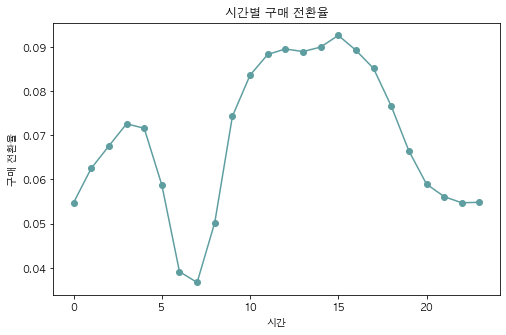

In [143]:
# 시간별 전환율 구하기
h_visit = df_oct.groupby('event_hour')['user_session'].nunique()        # 시간별 방문 수
h_purchase = df_purchase.groupby(['event_hour']).event_hour.count()     # 시간별 구매 수

h_conversion = pd.DataFrame(h_purchase/h_visit)     # 시간대별 구매 전환율
#---------------------------------------------------
# 시간별 구매전환율 시각화하기
x = h_conversion.index
y = h_conversion[0]

# 그래프 설정
plt.rcParams['figure.figsize'] = (8,5)
plt.plot(x, y, marker='o', color='#5F9EA0')

# 제목 및 축 설정
plt.title('시간별 구매 전환율');
plt.xlabel('시간')
plt.ylabel('구매 전환율')

plt.show();

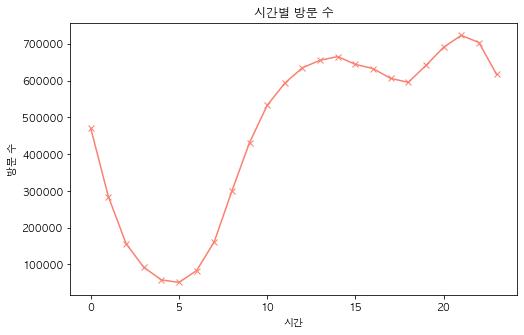

In [136]:
# 시간대별 방문 수 시각화
y1 = df_oct[df_oct['event_type']=='view'].groupby(['event_hour']).user_session.nunique()
x1 = df_oct[df_oct['event_type']=='view'].groupby(['event_hour']).user_session.nunique().index
plt.rcParams['figure.figsize'] = (8,5)
plt.plot(x1, y1, marker='x', color='#FA8072')

# 제목 및 축 설정
plt.title('시간별 방문 수');
plt.xlabel('시간') 
plt.ylabel('방문 수')

plt.show();

- 시간별 방뮨 유저 수랑 양상이 비슷함

In [43]:
h_conversion[0].sort_values(ascending=False)    # 정확히 수치로 보기 위해 내림차순 정렬해서 확인

event_hour
13    0.092596
12    0.089940
10    0.089516
14    0.089217
11    0.088928
9     0.088279
15    0.085109
8     0.083584
16    0.076607
7     0.074302
1     0.072594
2     0.071588
0     0.067588
17    0.066481
23    0.062226
18    0.058963
3     0.058747
19    0.056128
21    0.054851
20    0.054729
22    0.054438
6     0.050269
4     0.039160
5     0.036719
Name: 0, dtype: float64

In [137]:
y1.sort_values(ascending=False)

event_hour
21    722820
22    703380
20    690514
14    665087
13    655132
15    643879
19    641162
12    634776
16    632419
23    616644
17    605624
18    595145
11    592978
10    532551
0     469993
9     431221
8     299509
1     284168
7     161393
2     156569
3      92251
6      83051
4      57789
5      50786
Name: user_session, dtype: int64

-----
### 👇🏼 가설 2

In [138]:
# 접속 시간 구하기
# 1) user_session을 기준으로 구하기
session_visits = df_oct.groupby('user_session').event_time.max() - df_oct.groupby('user_session').event_time.min()  
session_visits  # 확인

user_session
00000042-3e3f-42f9-810d-f3d264139c50   0 days 00:00:35
00000056-a206-40dd-b174-a072550fa38c   0 days 00:08:13
00000083-8816-4d58-a9b8-f52f54186edc   0 days 00:09:45
000001fd-1f89-45e8-a3ce-fe3218cabfad   0 days 00:08:29
000003eb-b63e-45d9-9f26-f229057c654a   0 days 00:00:00
                                             ...      
fffff79f-a682-4f63-ad94-8364fe3d648f   0 days 00:00:16
fffff7e1-9294-4d6c-8482-e1438ba88380   0 days 00:04:04
fffff8d4-d31c-4066-a00b-2ace84d33640   0 days 00:10:22
fffffa1b-a6f0-483a-8f4b-30db242889b6   0 days 00:00:00
fffffc65-7ce9-435c-8b72-1d9f7062fe77   0 days 00:00:31
Name: event_time, Length: 10200970, dtype: timedelta64[ns]

In [148]:
# 접속 시간 구하기
# 2) user_id 기준으로 구하기
id_visits = (df_oct.groupby('user_id').event_time.max() - df_oct.groupby('user_id').event_time.min())
id_visits   # 확인

user_id
33869381     0 days 00:00:00
183503497    0 days 00:00:00
184265397   10 days 23:34:51
195082191    0 days 00:00:00
200673532    2 days 23:23:45
                  ...       
567211713    0 days 00:00:10
567211734    0 days 00:00:00
567211736    0 days 00:00:00
567211758    0 days 00:00:05
567211839    0 days 00:00:05
Name: event_time, Length: 3223907, dtype: timedelta64[ns]

In [149]:
# 접속 시간 df 만들기
access_time_df = pd.DataFrame(id_visits)     # 변수 이름 재설정 및 df화하기
access_time_df.rename(columns = {'event_time' : 'access_time'}, inplace = True)  

# 시각화 전에 access_time을 초로 단위를 변환해서 float으로 타입 변환시키기
access_time_df['access_time'] = access_time_df['access_time'] / np.timedelta64(1, 's')

##### **▶️ user_session과 user_id로 접속 시간을 직접 구한 결과를 통해 user_id를 기준으로 접속 시간을 구하기로 함**
----
#### 1. **원본 데이터**를 가지고 진행하기

In [150]:
# 유저별 구매전환율 구하기
# 1) 먼저 방문 횟수 구하기
user_view = pd.DataFrame(users_visits) 

# 앞의 access_time_df랑 합치기
access_time_df = pd.concat([access_time_df, user_view], axis=1) 
access_time_df

access_time  user_v
user_id                       
33869381           0.0       1
183503497          0.0       1
184265397     948891.0       2
195082191          0.0       1
200673532     257025.0       3
...                ...     ...
567211713         10.0       1
567211734          0.0       1
567211736          0.0       1
567211758          5.0       1
567211839          5.0       1

[3223907 rows x 2 columns]

In [151]:
# 유저별 구매전환율 구하기
# 2) 구매 건수 구하기
user_purchase = pd.DataFrame(users_purchases)

# 앞의 access_time_df랑 합치기
access_time_df = pd.concat([access_time_df, user_purchase], axis=1) 

# 결측치 확인
access_time_df.isna().sum()     # 구매 건수의 결측치는 데이터가 없어서 발생

access_time          0
user_v               0
user_p         2851163
dtype: int64

In [152]:
# 구매 건수의 결측치를 0으로 대체해주기
access_time_df['user_p'].fillna(0, inplace=True)

# 유저별 구매 전환율 구하기
access_time_df['user_conversion'] = (access_time_df['user_p'] / access_time_df['user_v'])
access_time_df

access_time  user_v  user_p  user_conversion
user_id                                                
33869381           0.0       1     0.0              0.0
183503497          0.0       1     0.0              0.0
184265397     948891.0       2     0.0              0.0
195082191          0.0       1     0.0              0.0
200673532     257025.0       3     0.0              0.0
...                ...     ...     ...              ...
567211713         10.0       1     0.0              0.0
567211734          0.0       1     0.0              0.0
567211736          0.0       1     0.0              0.0
567211758          5.0       1     0.0              0.0
567211839          5.0       1     0.0              0.0

[3223907 rows x 4 columns]

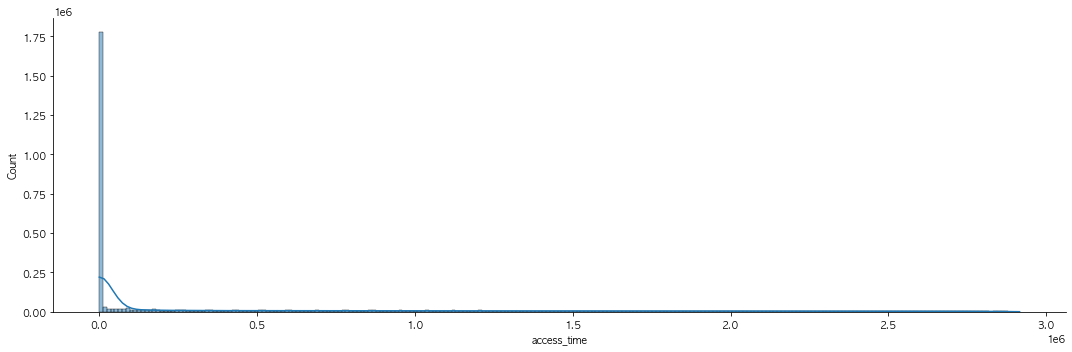

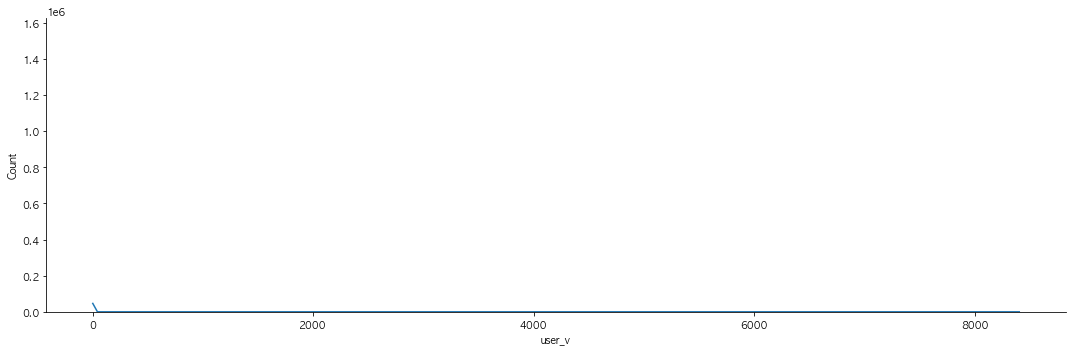

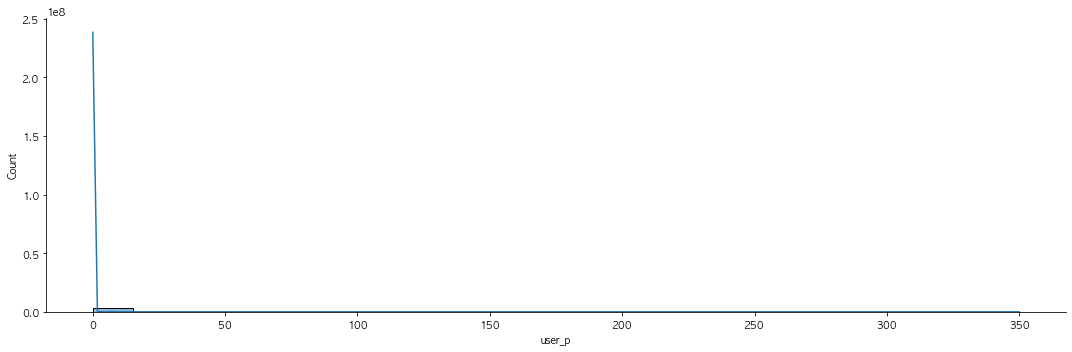

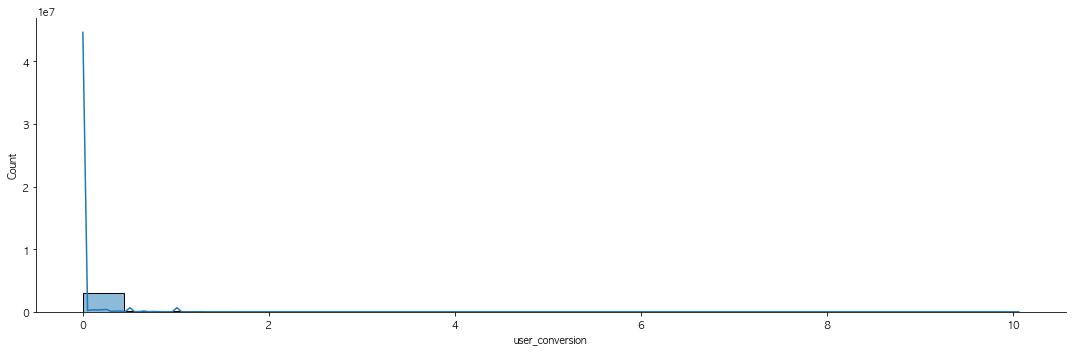

In [153]:
# 각 특성들의 분포 확인
colss = access_time_df.columns
for i in colss:
  sns.displot(access_time_df[i], height = 5, aspect = 3, kde=True);

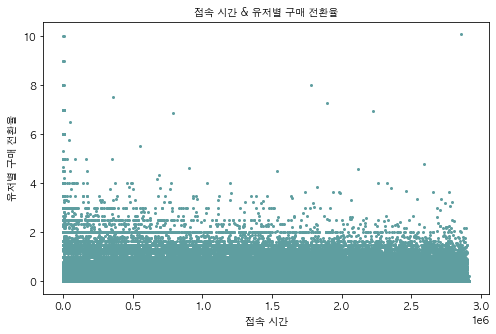

In [154]:
# 접속 시간 & 유저별 구매 전환율 시각화
plt.scatter(access_time_df['access_time'], access_time_df['user_conversion'], s = 4, color='#5F9EA0')
plt.title('접속 시간 & 유저별 구매 전환율', fontsize=10) 
plt.xlabel('접속 시간', fontsize=10)
plt.ylabel('유저별 구매 전환율', fontsize=10)
plt.show();

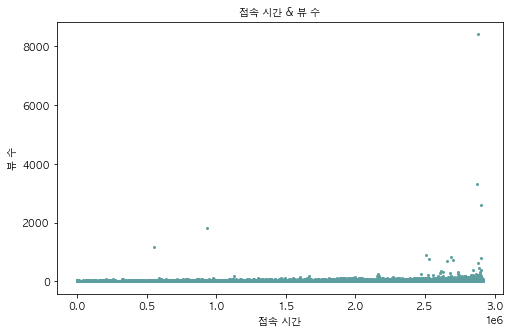

In [155]:
# 접속 시간 & 뷰 수 시각화
plt.scatter(access_time_df['access_time'], access_time_df['user_v'], s = 4, color='#5F9EA0')
plt.title('접속 시간 & 뷰 수', fontsize=10) 
plt.xlabel('접속 시간', fontsize=10)
plt.ylabel('뷰 수', fontsize=10)
plt.show();

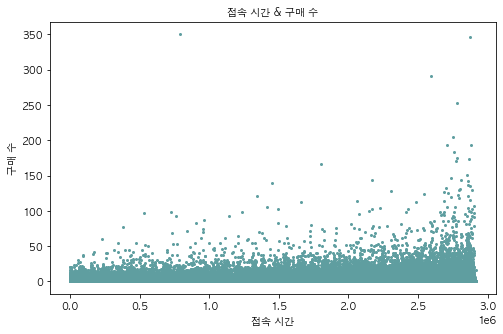

In [156]:
# 접속 시간 & 구매 수 시각화
plt.scatter(access_time_df['access_time'], access_time_df['user_p'], s = 4, color='#5F9EA0')
plt.title('접속 시간 & 구매 수', fontsize=10) 
plt.xlabel('접속 시간', fontsize=10)
plt.ylabel('구매 수', fontsize=10)
plt.show();

### **🔍 정리**
##### 👉🏼 산점도를 통해

    - 가설 2와 다르게 접속 시간이 상대적으로 짧은 유저들의 구매 전환율이 더 높은 것을 알 수 있음
    - 또한 접속 시간이 늘어날수록 뷰 수도 함께 증가하는 듯 보이지만 아주 미세한 듯
    - 구매 건수 또한 접속 시간이 늘어날수록 함께 늘어나는 것을 볼 수 있음

-----
#### 2. **값이 0**인 데이터 **제거**하고 진행하기

In [157]:
# 값이 0인 데이터 제거해서 진행해보기
access_time_zerox = access_time_df[access_time_df['user_p'] > 0] 
access_time_zerox = access_time_df[access_time_df['user_v'] > 0]

access_time_zerox

access_time  user_v  user_p  user_conversion
user_id                                                
33869381           0.0       1     0.0              0.0
183503497          0.0       1     0.0              0.0
184265397     948891.0       2     0.0              0.0
195082191          0.0       1     0.0              0.0
200673532     257025.0       3     0.0              0.0
...                ...     ...     ...              ...
567211713         10.0       1     0.0              0.0
567211734          0.0       1     0.0              0.0
567211736          0.0       1     0.0              0.0
567211758          5.0       1     0.0              0.0
567211839          5.0       1     0.0              0.0

[3223907 rows x 4 columns]

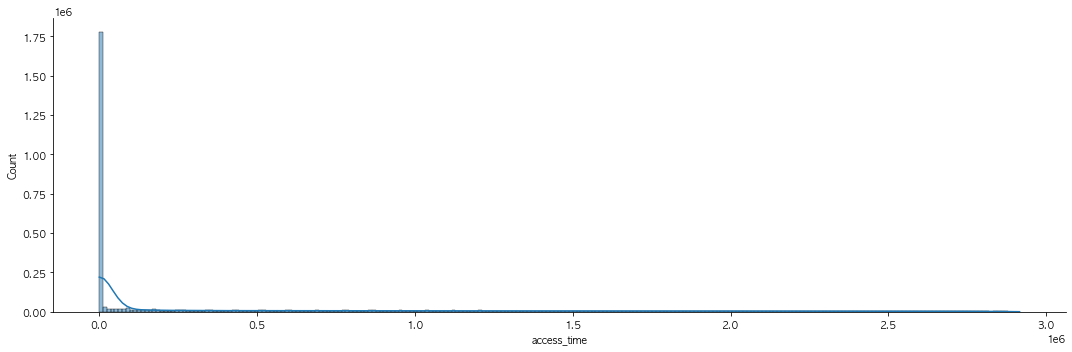

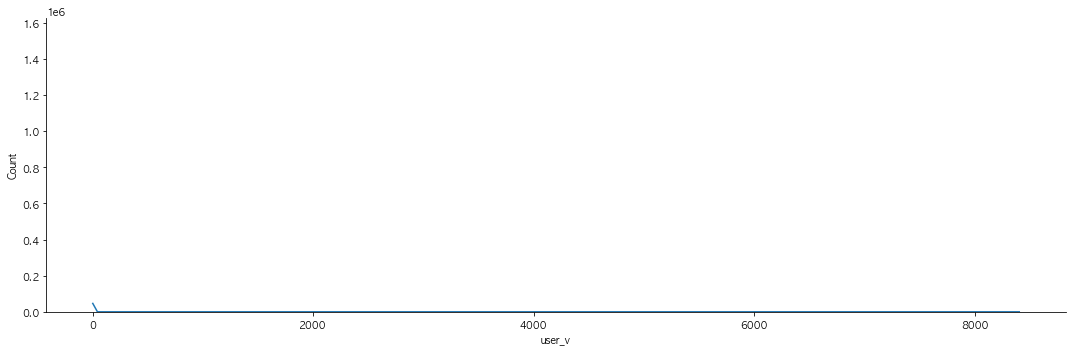

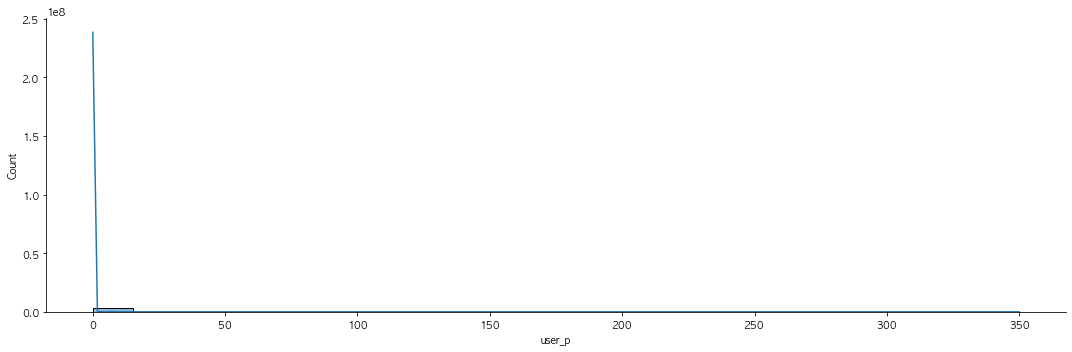

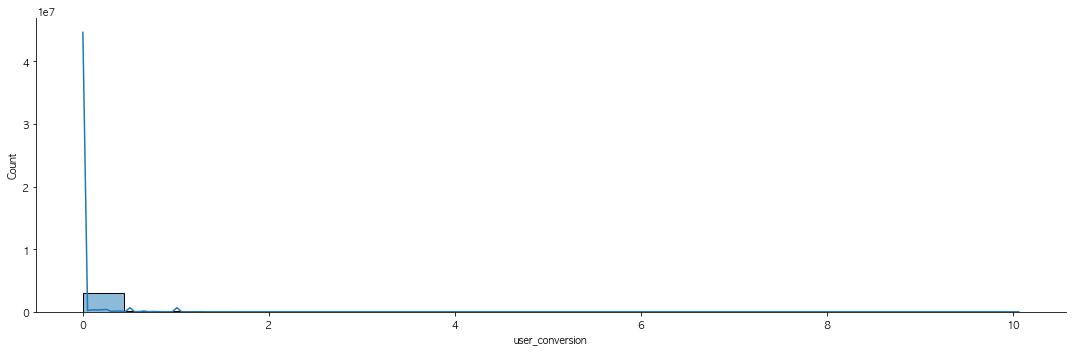

In [158]:
# 각 특성들의 분포 확인
colss = access_time_zerox.columns
for i in colss:
  sns.displot(access_time_zerox[i], height = 5, aspect = 3, kde=True);

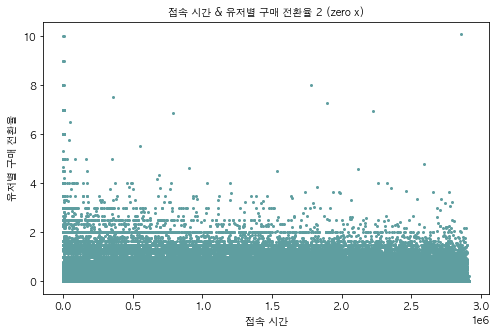

In [159]:
# 접속 시간 & 유저별 구매 전환율 시각화
plt.scatter(access_time_zerox['access_time'], access_time_zerox['user_conversion'], s = 4, color='#5F9EA0')
plt.title('접속 시간 & 유저별 구매 전환율 2 (zero x)', fontsize=10) 
plt.xlabel('접속 시간', fontsize=10)
plt.ylabel('유저별 구매 전환율', fontsize=10)
plt.show();

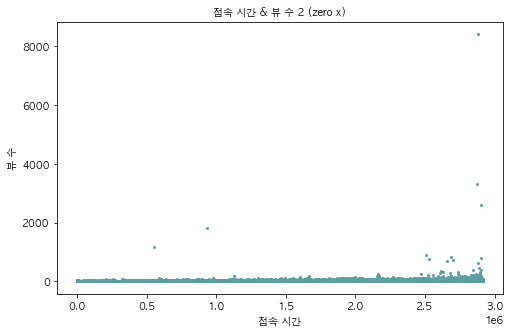

In [160]:
# 접속 시간 & 뷰 수 시각화
plt.scatter(access_time_zerox['access_time'], access_time_zerox['user_v'], s = 4, color='#5F9EA0')
plt.title('접속 시간 & 뷰 수 2 (zero x)', fontsize=10) 
plt.xlabel('접속 시간', fontsize=10)
plt.ylabel('뷰 수', fontsize=10)
plt.show();

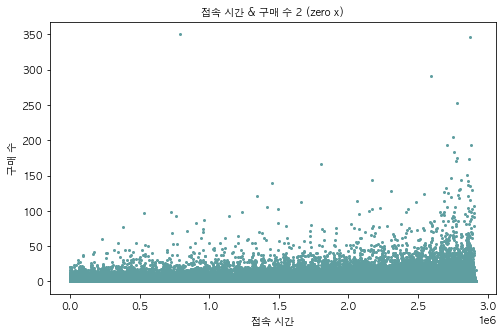

In [161]:
# 접속 시간 & 구매 수 시각화
plt.scatter(access_time_zerox['access_time'], access_time_zerox['user_p'], s = 4, color='#5F9EA0')
plt.title('접속 시간 & 구매 수 2 (zero x)', fontsize=10) 
plt.xlabel('접속 시간', fontsize=10)
plt.ylabel('구매 수', fontsize=10)
plt.show();

### **🔍 정리 2**
##### 👉🏼 산점도를 통해

    - 값이 0인 데이터를 제거해도 세 산점도의 분포 양상에는 큰 차이는 없어 보임
    - 접속 시간이 짧을수록 구매 전환율이 증가하는 경향이 있음
    - 반면 뷰 수와 구매 수는 접속 시간이 늘어날수록 증가함

----

### 👇🏼 가설 3
#### 브랜드&유저 행동 간의 연관성
##### 카이제곱검정

In [18]:
chi_res1 = chi2_contingency(pd.crosstab(df10['brand'], df10['event_type']))
print('브랜드와 유저 행동 간의 Chi2 Statistic: {}, p-value: {}'.format(chi_res1[0], chi_res1[1]))

브랜드와 유저 행동 간의 Chi2 Statistic: 1241219.4501597928, p-value: 0.0


#### **🔍 정리**
- pvalue = 0.0 이므로 브랜드와 유저 행동 간의 연관성이 있다고 볼 수 있음

------
#### 1. 브랜드 유무에 따른 EDA

In [120]:
# 브랜드 표기가 되어있지 않은 경우: brand == 'unknown', 브랜드가 없는 경우를 의미하는 걸로 추정함
# 브랜드가 있는 경우와 없는 경우의 데이터를 구분함
unknown_df = df_oct[df_oct['brand'] == 'unknown']
brand_df = df_oct[df_oct['brand'] != 'unknown']

print('브랜드 o인 df의 brand 종류: \n', brand_df['brand'].value_counts())
print('-'*30)
print('브랜드 x인 df의 brand 종류: \n', unknown_df['brand'].value_counts())

브랜드 o인 df의 brand 종류: 
 samsung         5808101
apple           4536199
xiaomi          3396168
huawei          1213553
lucente          715699
                 ...   
harmankardon          1
steffilove            1
homs                  1
sonifer               1
unknown               0
Name: brand, Length: 3544, dtype: int64
------------------------------
브랜드 x인 df의 brand 종류: 
 unknown       6679960
a-case              0
on                  0
olmeko              0
olmio               0
               ...   
galacticos          0
galanz              0
galaxy              0
gamdias             0
zyxel               0
Name: brand, Length: 3544, dtype: int64


In [144]:
# 브랜드가 없는 경우의 event_type 비중 확인하기
print(unknown_df['event_type'].value_counts())
print('-'*30)

# 브랜드가 있는 경우의 event_type 비중 확인하기
print(brand_df['event_type'].value_counts())

view        6621180
purchase      63625
cart          19379
Name: event_type, dtype: int64
------------------------------
view        38452101
cart          964711
purchase      744718
Name: event_type, dtype: int64


#### **🔍 정리**
- 두 df의 view/cart/purchase 건수 비교하기
    - 브랜드가 없는 경우의 뷰잉 건수: 5971446 < 브랜드가 있는 경우의 뷰잉 건수: 34739430
    - 브랜드가 없는 경우의 장바구니 건수: 18656 < 브랜드가 있는 경우의 장바구니 건수: 907710
    - 브랜드가 없는 경우의 구매 건수: 58305 < 브랜드가 있는 경우의 장바구니 건수: 684544
--------
- 두 df의 view/cart/purchase의 비중을 비교하면,
    - 브랜드가 없는 경우: purchase가 cart보다 비중이 높음
        - 이는 브랜드가 없는 상품의 경우 뷰잉을 하고 장바구니에 상품을 넣은 후에 구매를 진행하는 것이 아니라, 뷰잉하고 구매 결심이 들면 바로 구매를 진행하는 경향이 있음을 추측해볼 수 있다.
    - 브랜드가 있는 경우: cart의 비중이 purchase보다 높음
        - 즉 브랜드가 있는 상품은 대체로 고객이 구매하기 전에 장바구니에 넣고 구매를 진행하는 경우가 많다는 것으로 생각해볼 수 있다.

#### 2. 구매전환율 구하기

In [121]:
# 브랜드 있는 경우와 없는 경우의 뷰잉 -> 구매 전환율(view -> purchase) 구하기

# 1) 브랜드 없는 경우
# 뷰잉 수 구하기
unknown_visit = unknown_df.groupby(['event_date']).user_session.nunique()        

# 일별 구매 수 구하기
unknown_sales = unknown_df[unknown_df['event_type']=='purchase'].groupby(['event_date']).user_session.count()
# -----------------------------------------------------------------------
# 2) 브랜드 있는 경우
# 뷰잉 수 구하기
brand_visit = brand_df.groupby(['event_date']).user_session.nunique()        

# 일별 구매 수 구하기
brand_sales = brand_df[brand_df['event_type']=='purchase'].groupby(['event_date']).user_session.count()
# -----------------------------------------------------------------------
# 일별 구매전환율(view -> purchase) 구하기 -> df화
unknown_conversion = pd.DataFrame(unknown_sales/unknown_visit)
brand_conversion = pd.DataFrame(brand_sales/brand_visit)

# df 인덱스 초기화
unknown_conversion.reset_index(inplace=True)
brand_conversion.reset_index(inplace=True)
brand_conversion

event_date  user_session
0  2019-10-01      0.072771
1  2019-10-02      0.073854
2  2019-10-03      0.077263
3  2019-10-04      0.090326
4  2019-10-05      0.084784
5  2019-10-06      0.080748
6  2019-10-07      0.080239
7  2019-10-08      0.074516
8  2019-10-09      0.075322
9  2019-10-10      0.073392
10 2019-10-11      0.077665
11 2019-10-12      0.082249
12 2019-10-13      0.085535
13 2019-10-14      0.092511
14 2019-10-15      0.078244
15 2019-10-16      0.095733
16 2019-10-17      0.093356
17 2019-10-18      0.079743
18 2019-10-19      0.077383
19 2019-10-20      0.073164
20 2019-10-21      0.079344
21 2019-10-22      0.080628
22 2019-10-23      0.079829
23 2019-10-24      0.081481
24 2019-10-25      0.074944
25 2019-10-26      0.077775
26 2019-10-27      0.080436
27 2019-10-28      0.075052
28 2019-10-29      0.074231
29 2019-10-30      0.074515
30 2019-10-31      0.071695
31 2019-11-01      0.070348
32 2019-11-02      0.065595
33 2019-11-03      0.062547

#### 3. 시각화

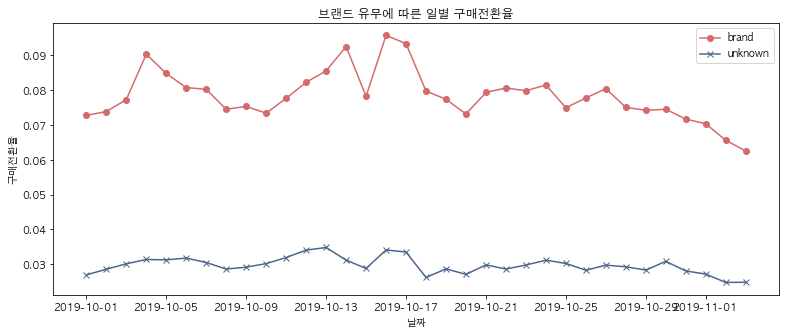

In [164]:
# 브랜드 유무에 따른 일별 구매전환율 시각화

# x,y value 설정
x1 = brand_conversion['event_date']
y1 = brand_conversion['user_session']
x2 = unknown_conversion['event_date']
y2 = unknown_conversion['user_session']

# 그래프 그리기
plt.rcParams['figure.figsize'] = (13,5)
plt.plot(x1, y1, marker='o', color='#D46A6A')
plt.plot(x2, y2, marker='x', color='#4D658D')

# 제목 및 축 설정
plt.legend(['brand', 'unknown'])
plt.title('브랜드 유무에 따른 일별 구매전환율')
plt.xlabel('날짜')
plt.ylabel('구매전환율')
# plt.ticklabel_format(axis='y',style='plain') #y축 과학표기 제거
plt.show();

#### **🔍 정리**
- 브랜드가 있을 때, 즉 브랜드가 표기되었을 떄(brand) 일별 구매전환율이 대체로 약 7~9%에 머물고 있음을 알 수 있음
- 브랜드가 없는 경우 = 브랜드가 표기되어있지 않은 경우(unknown)에는 일별 구매전환율이 대체로 약 2~3%에 머물고 있음을 알 수 있음

##### **👉🏼 두 전환율 간의 차이가 대체로 약 4~6% 정도 임을 확인할 수 있음**

--------
### 🔥 브랜드에 따른 구매전환율

In [122]:
brand_visits = brand_df.groupby('brand').user_session.nunique() # 브랜드별 방문 수
brand_sales = brand_df[brand_df['event_type']=='purchase'].groupby('brand').event_type.count()  # 브랜드별 구매 수

In [166]:
# 브랜드별 구매 수를 내림차순으로 구해보기
pd.DataFrame(df_purchase.groupby('category_code').event_type.count().sort_values(ascending = False))

event_type
category_code                            
electronics.smartphone             367064
unknown                            189918
electronics.audio.headphone         33011
electronics.video.tv                23424
electronics.clocks                  19413
...                                   ...
apparel.shoes.espadrilles               0
apparel.shoes.step_ins                  0
country_yard.furniture.bench            0
country_yard.furniture.hammok           0
auto.accessories.anti_freeze            0

[127 rows x 1 columns]

In [124]:
b_conversion =  pd.DataFrame(brand_visits / brand_sales, columns=['brand_conversion'])  # 브랜드별 구매전환율
b_conversion

brand_conversion
brand                               
a-case                     87.921875
a-derma                   174.000000
a-elita                          inf
a-mega                     39.333333
aardwolf                         inf
...                              ...
zubr                       77.736842
zuru                       36.000000
zvezda                           inf
zwillingjahenckels               inf
zyxel                            inf

[3544 rows x 1 columns]

In [125]:
# inf 값 NaN으로 처리하고 제거하기
b_conversion = b_conversion.replace([np.inf, -np.inf], np.nan)
b_conversion.brand_conversion.fillna(0,inplace=True)
b_conversion

brand_conversion
brand                               
a-case                     87.921875
a-derma                   174.000000
a-elita                     0.000000
a-mega                     39.333333
aardwolf                    0.000000
...                              ...
zubr                       77.736842
zuru                       36.000000
zvezda                      0.000000
zwillingjahenckels          0.000000
zyxel                       0.000000

[3544 rows x 1 columns]

### 브랜드별 구매 전환율 top 10

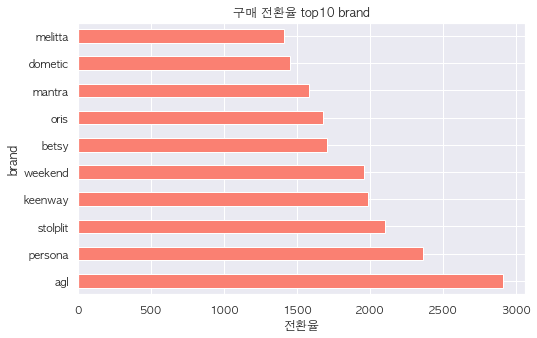

In [126]:
# 구매 전환율 top10 brand
b_conversion['brand_conversion'].nlargest(10).plot(kind='barh', figsize=(8,5), color='#FA8072')
plt.xlabel('전환율')
plt.ylabel('brand')
plt.title('구매 전환율 top10 brand');

-----
#### **t-test 검정**

In [147]:
# t-test 검정
print('test result: ', stats.ttest_ind(brand_conversion['user_session'], unknown_conversion['user_session']))

test result:  Ttest_indResult(statistic=37.16042310760036, pvalue=5.634619828049219e-46)


In [148]:
# 실제로 평균값 구해보기
(brand_conversion['user_session'].mean(), unknown_conversion['user_session'].mean())

(0.07859602224298504, 0.02977797718726225)

#### **🔍 정리**
- pvalue=5.634619828049219e-46으로 0에 가까운 값 -> 브랜드 유무에 따른 평균 접속 -> 구매의 전환율은 같다고 할 수 없음
- 실제로 두 df의 평균 구매전환율 비교해보니까 값이 크게 차이남

------
### 👇🏼 가설 4
#### 카테고리 코드 & 유저 행동 간 연관성
##### 카이제곱검정

In [37]:
chi_res1 = chi2_contingency(pd.crosstab(df10['category_code'], df10['event_type']))
print('카테고리와 유저 행동 간의 Chi2 Statistic: {}, p-value: {}'.format(chi_res1[0], chi_res1[1]))

카테고리와 유저 행동 간의 Chi2 Statistic: 890788.0199486198, p-value: 0.0


#### **🔍 정리**
- p-value=0.0 이므로 카테고리와 유저 행동 간 연관성을 확인함

#### 1. 시각화

In [72]:
# categorized된 상품과 그렇지 않은 상품을 구분

# categorized 안 된 상품의 df
no_category = df_oct[df_oct['category_code']=='unknown']

# categorized된 상품의 df
categorized = df_oct[df_oct['category_code'] != 'unknown']

# 확인
categorized['category_code'].value_counts()

electronics.smartphone          12642672
electronics.clocks               1436204
computers.notebook               1259226
electronics.video.tv             1245656
electronics.audio.headphone      1210314
                                  ...   
apparel.shorts                       668
auto.accessories.anti_freeze         553
apparel.jacket                       436
country_yard.furniture.bench         190
unknown                                0
Name: category_code, Length: 127, dtype: int64

In [73]:
# 카테고리 있는 경우의 일별 view 수 구하기
view_condition2 = categorized[categorized['event_type'] == 'view']
categorized_view = view_condition2.groupby(['event_date'])['user_session'].nunique()

# 카테고리 없는 경우의 일별 view 수 구하기
view_condition = no_category[no_category['event_type'] == 'view']
no_categorized_view = view_condition.groupby(['event_date'])['user_session'].nunique()

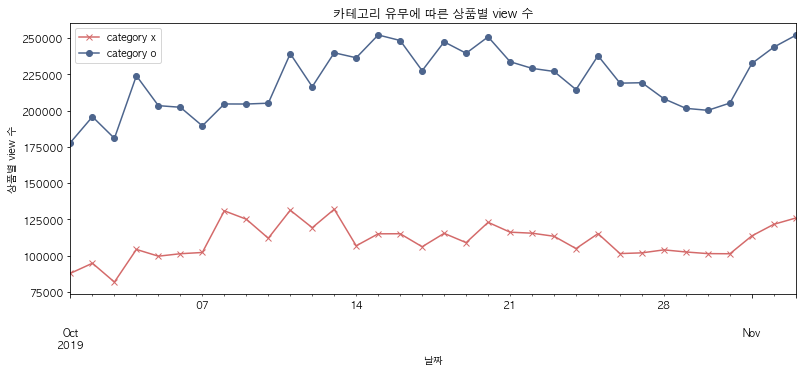

In [74]:
# 카테고리 유무에 따른 상품별 view 수 시각화
# 그래프 그리기
plt.rcParams['figure.figsize'] = (13,5)
no_categorized_view.plot(kind = 'line', marker='x', color='#D46A6A')
categorized_view.plot(kind = 'line', marker='o', color='#4D658D')

# 제목 및 축 설정
plt.legend(['category x', 'category o'])
plt.title('카테고리 유무에 따른 상품별 view 수')
plt.xlabel('날짜')
plt.ylabel('상품별 view 수')
# plt.ticklabel_format(axis='y',style='plain') #y축 과학표기 제거
plt.show();

#### t-test 검정
- 카테고리화된 상품들과 그렇지 않은 상품들의 일별 접속 수에 대한 t-test 검정 실시

In [153]:
# t-test
print('t-test result: ', stats.ttest_ind(no_categorized_view, categorized_view))

t-test result:  Ttest_indResult(statistic=-27.166117517930733, pvalue=1.5138770184568762e-37)


In [154]:
(no_categorized_view.mean(), categorized_view.mean())

(110438.08823529411, 221084.58823529413)

#### **🔍 정리**
- pvalue=1.5138770184568762e-37으로 0에 가까운 아주 작은 값 -> 카테고리 유무에 따른 상품별 view 수는 같지 않다고 할 수 있음
- 실제로도 categorized 여부에 따라 평균 방문 수에 차이가 있음
-----

## 상품 분석
### 🔥 categorized된 상품 중 **구매전환율이 높은 top50**

In [75]:
# 상품별 구매 전환율 구하기
product_conversion = pd.DataFrame(view_condition2['product_id'].value_counts())     # 상품별 방문 수를 df화함
product_conversion.rename(columns = {'product_id' : 'product_v'}, inplace = True)    # 컬럼 이름 변경

product_p = pd.DataFrame(categorized[categorized['event_type'] == 'purchase']['product_id'].value_counts())     # 상품별 구매 수를 df화함
product_p.rename(columns = {'product_id' : 'product_p'}, inplace = True)    # 컬럼 이름 변경

product_conversion = pd.merge(product_conversion, product_p, left_index=True, right_index=True, how='inner')     # 두 df를 인덱스를 기준으로 inner-merge함
product_conversion

product_v  product_p
1004856      459873      31646
1004767      416177      23778
1005115      364395      13976
1004249      228623       9829
1004833      222384      13926
...             ...        ...
5701303           1          1
16200203          1          1
12901176          1          1
12901272          1          1
14701426          1          1

[20607 rows x 2 columns]

In [166]:
# 결측치 확인
product_conversion.isna().sum()

product_v    0
product_p    0
dtype: int64

In [76]:
# 상품별 구매 전환율 구하기
product_conversion['product_conversion'] = product_conversion['product_p']/product_conversion['product_v']

# categorized df랑 merge
categorized_conversion  = pd.merge(categorized, product_conversion, left_index=True, 
right_index=True, how='inner')     # 두 df를 인덱스를 기준으로 inner-merge함

In [77]:
# top 20의 카테고리 코드와 브랜드를 출력해서 어떤 제품군/브랜드가 많은지 확인
categorized_conversion.nlargest(20, 'product_conversion') [['category_code', 'brand', 'product_conversion']]

category_code     brand  product_conversion
5701303                       apparel.shoes  marcomen            1.000000
5701317       appliances.environment.vacuum   samsung            1.000000
12901176  appliances.environment.air_heater   unknown            1.000000
14701426             electronics.smartphone     apple            1.000000
16200203             electronics.smartphone    xiaomi            1.000000
20500270         appliances.personal.scales   polaris            1.000000
21405915             electronics.smartphone     apple            1.000000
13800642             electronics.smartphone    xiaomi            0.666667
6902324              electronics.smartphone    huawei            0.500000
8902645                   computers.desktop    pulser            0.500000
12900925             electronics.smartphone     apple            0.500000
12901177             electronics.smartphone   samsung            0.500000
35108809               electronics.video.tv     artel            0.500000
3701009       computers.peripherals.printer     epson            0.333333
13900014                 computers.notebook        hp            0.333333
14100045            appliances.kitchen.oven  dauscher            0.333333
20200406                 apparel.shoes.keds   strobbs            0.333333
12900186             electronics.smartphone   samsung            0.307692
12900452        computers.peripherals.mouse       msi            0.250000
21400852                 computers.notebook      asus            0.250000

### 🔍 정리
- categorized된 상품 중에서 구매 전환율이 가장 높은 top10을 추출
- 이 상품들의 상품군과 브랜드를 도출해보니 **smartphone과 가전에 대한 구매 전환율이 높음**을 확인할 수 있음
-----
## 유저 분석
### 1. 제품을 보기만하고 구매하지 않은 사람들의 관심 제품

In [15]:
# 각각의 event를 한 사람들
view = df_oct[df_oct['event_type']=='view']['user_id']
cart = df_oct[df_oct['event_type']=='cart']['user_id']
purchase = df_oct[df_oct['event_type']=='purchase']['user_id']

# # view만 한사람 = view - cart - purchase
view_only_list = set(view) - set(cart) - set(purchase)

# # 데이터프레임
view_only_df = df_oct[df_oct['user_id'].isin(view_only_list)]
view_only_df.shape

(26383467, 14)

In [16]:
view_only_df['category_code'].value_counts().nlargest(21)   

unknown                             8885675
electronics.smartphone              6447101
electronics.clocks                   837634
computers.notebook                   728769
electronics.video.tv                 649765
electronics.audio.headphone          588577
appliances.kitchen.refrigerators     583866
apparel.shoes                        559709
appliances.kitchen.washer            521075
appliances.environment.vacuum        483926
auto.accessories.player              314503
apparel.shoes.keds                   288906
computers.desktop                    285158
furniture.bedroom.bed                275424
furniture.living_room.cabinet        226800
electronics.audio.subwoofer          195443
electronics.tablet                   192986
furniture.living_room.sofa           183841
construction.tools.drill             164436
kids.carriage                        145662
electronics.telephone                142586
Name: category_code, dtype: int64

In [17]:
view_only_df['brand'].value_counts().nlargest(21)

unknown     4170216
samsung     2925094
apple       2286470
xiaomi      1746091
huawei       644130
lucente      444628
bosch        358987
lg           344303
oppo         289170
sony         282464
acer         266790
cordiant     223609
lenovo       216266
artel        206512
respect      195869
hp           195259
dauscher     185115
casio        181060
indesit      174397
stels        167189
philips      164819
Name: brand, dtype: int64

### 2. 구매 건수 top20 유저 분석

In [18]:
# 유저별 뷰 수 구하기
users_visits = pd.DataFrame(df_oct.groupby(['user_id']).user_session.nunique())  
# users_visits.reset_index(inplace=True)    
users_visits.rename(columns = {'user_session' : 'user_v'}, inplace = True) 

# 유저별 구매 수 구하기
users_purchases = pd.DataFrame(df_purchase.groupby(['user_id']).event_type.count())
# users_purchases.reset_index(inplace=True)    
users_purchases.rename(columns = {'event_type' : 'user_p'}, inplace = True)    # 컬럼 이름 변경

users_conv = pd.merge(users_visits, users_purchases, left_index=True, right_index=True, how='inner')     # 두 df를 인덱스를 기준으로 inner-merge함
users_conv['conversionrate'] = users_conv['user_p']/users_conv['user_v']        # 유저별 구매 전환율
users_conv

user_v  user_p  conversionrate
user_id                                  
264649825       5       2        0.400000
303160429       2       1        0.500000
340041246       3       4        1.333333
356520186       8       1        0.125000
371877401      19       1        0.052632
...           ...     ...             ...
567208012       1       1        1.000000
567209038       1       1        1.000000
567209179       1       1        1.000000
567209184       1       2        2.000000
567210078       1       1        1.000000

[372744 rows x 3 columns]

In [19]:
# 구매 건수 구하기
# 구매 건수 top20에 해당하는 고객들의 id
idlist = list(users_conv.nlargest(20, 'user_p').index)  # list에 할당하기  

# 구매 top 20의 유저 정보 모으기
# 일단 id 별로 별도의 df로 추출
df1 = df_oct[df_oct['user_id'] == idlist[0]]
df2 = df_oct[df_oct['user_id'] == idlist[1]]
df3 = df_oct[df_oct['user_id'] == idlist[2]]
df4 = df_oct[df_oct['user_id'] == idlist[3]]
df5 = df_oct[df_oct['user_id'] == idlist[4]]
df6 = df_oct[df_oct['user_id'] == idlist[5]]
df7 = df_oct[df_oct['user_id'] == idlist[6]]
df8 = df_oct[df_oct['user_id'] == idlist[7]]
df9 = df_oct[df_oct['user_id'] == idlist[8]]
df10 = df_oct[df_oct['user_id'] == idlist[9]]
df11 = df_oct[df_oct['user_id'] == idlist[10]]
df12 = df_oct[df_oct['user_id'] == idlist[11]]
df13 = df_oct[df_oct['user_id'] == idlist[12]]
df14 = df_oct[df_oct['user_id'] == idlist[13]]
df15 = df_oct[df_oct['user_id'] == idlist[14]]
df16 = df_oct[df_oct['user_id'] == idlist[15]]
df17 = df_oct[df_oct['user_id'] == idlist[16]]
df18 = df_oct[df_oct['user_id'] == idlist[17]]
df19 = df_oct[df_oct['user_id'] == idlist[18]]
df20 = df_oct[df_oct['user_id'] == idlist[19]]

In [20]:
# 하나의 df로 병합하기
df110 = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])
df1120 = pd.concat([df11, df12, df13, df14, df15, df16, df17, df18, df19, df20])

top20_pur = pd.concat([df110, df1120])
top20_pur

event_time event_type  product_id           category_code  \
34235778 2019-10-25 20:17:08       view     1004836  electronics.smartphone   
34329788 2019-10-25 21:16:02       view     1004836  electronics.smartphone   
34331772 2019-10-25 21:17:14   purchase     1004836  electronics.smartphone   
34333225 2019-10-25 21:18:08       view     1004836  electronics.smartphone   
34558690 2019-10-25 23:40:13       view     1004750  electronics.smartphone   
...                      ...        ...         ...                     ...   
46058497 2019-11-03 15:37:16       view     1004237  electronics.smartphone   
46058754 2019-11-03 15:37:26       cart     1004237  electronics.smartphone   
46104498 2019-11-03 16:08:22       view     1002544  electronics.smartphone   
46105181 2019-11-03 16:08:50       cart     1002544  electronics.smartphone   
46111309 2019-11-03 16:13:02   purchase     1002544  electronics.smartphone   

            brand        price    user_id  \
34235778  samsung   223.759995  564068124   
34329788  samsung   223.759995  564068124   
34331772  samsung   223.759995  564068124   
34333225  samsung   223.759995  564068124   
34558690  samsung   195.350006  564068124   
...           ...          ...        ...   
46058497    apple  1078.280029  535658024   
46058754    apple  1078.280029  535658024   
46104498    apple   458.130005  535658024   
46105181    apple   458.130005  535658024   
46111309    apple   458.130005  535658024   

                                  user_session event_date  event_month  \
34235778  e7c7cd8a-dff7-4808-9a5e-000e0ac824bc 2019-10-25           10   
34329788  e7c7cd8a-dff7-4808-9a5e-000e0ac824bc 2019-10-25           10   
34331772  e7c7cd8a-dff7-4808-9a5e-000e0ac824bc 2019-10-25           10   
34333225  e7c7cd8a-dff7-4808-9a5e-000e0ac824bc 2019-10-25           10   
34558690  11a8d7b5-5139-44d2-a4a8-96cb532d5b96 2019-10-25           10   
...                                        ...        ...          ...   
46058497  9f018b1d-f4c0-4aab-834a-8a59631578ac 2019-11-03           11   
46058754  9f018b1d-f4c0-4aab-834a-8a59631578ac 2019-11-03           11   
46104498  8261d507-f896-492c-8883-94953852833f 2019-11-03           11   
46105181  8261d507-f896-492c-8883-94953852833f 2019-11-03           11   
46111309  8261d507-f896-492c-8883-94953852833f 2019-11-03           11   

          event_day day_of_week  event_hour  event_week  
34235778         25      Friday          20          43  
34329788         25      Friday          21          43  
34331772         25      Friday          21          43  
34333225         25      Friday          21          43  
34558690         25      Friday          23          43  
...             ...         ...         ...         ...  
46058497          3      Sunday          15          44  
46058754          3      Sunday          15          44  
46104498          3      Sunday          16          44  
46105181          3      Sunday          16          44  
46111309          3      Sunday          16          44  

[16026 rows x 14 columns]

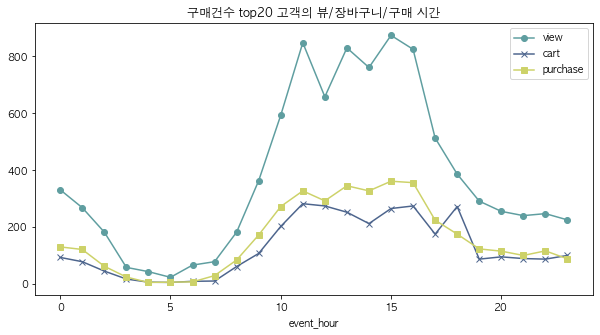

In [21]:
# 구매건수 top20의 방문 시간 확인하기
top20_pur[top20_pur['event_type'] == 'view'].groupby(['event_hour']).user_id.count().plot(kind='line', marker = 'o', figsize=(10,5), color = '#5F9EA0')
top20_pur[top20_pur['event_type'] == 'cart'].groupby(['event_hour']).user_id.count().plot(kind='line', marker = 'x', figsize=(10,5), color = '#4D658D')
top20_pur[top20_pur['event_type'] == 'purchase'].groupby(['event_hour']).user_id.count().plot(kind='line', marker = 's', figsize=(10,5), color = '#CDD269')
plt.legend(['view','cart','purchase'])

plt.title('구매건수 top20 고객의 뷰/장바구니/구매 시간');

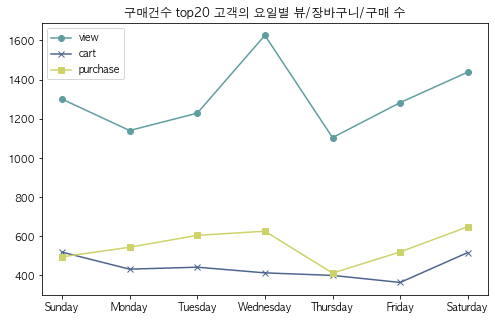

In [23]:
# 구매건수 top20의 요일별 장바구니 수 확인하기
top20v = pd.DataFrame(top20_pur[top20_pur['event_type'] == 'view'].groupby(['day_of_week']).user_id.count())
top20c = pd.DataFrame(top20_pur[top20_pur['event_type'] == 'cart'].groupby(['day_of_week']).user_id.count())
top20p = pd.DataFrame(top20_pur[top20_pur['event_type'] == 'purchase'].groupby(['day_of_week']).user_id.count())

weekday_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
top20v = top20v.loc[weekday_order]        # 일~토 순으로 요일 재정렬
# top20c = top20c.loc[weekday_order]        # 일~토 순으로 요일 재정렬
# top20p = top20p.loc[weekday_order]        # 일~토 순으로 요일 재정렬

x1 = top20v.index
y1 = top20v['user_id']
y2 = top20c['user_id']
y3 = top20p['user_id']

plt.plot(x1, y1, marker = 'o', color = '#5F9EA0')
plt.plot(x1, y2, marker = 'x', color = '#4D658D')
plt.plot(x1, y3, marker = 's', color = '#CDD269')
plt.legend(['view','cart','purchase'])

plt.title('구매건수 top20 고객의 요일별 뷰/장바구니/구매 수');

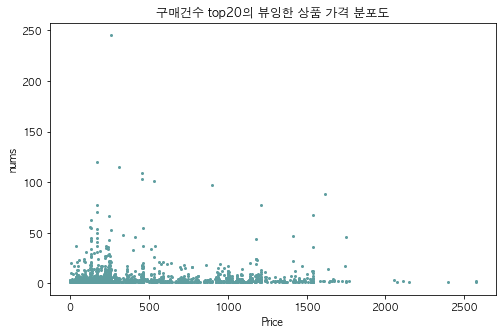

In [27]:
# top20의 뷰잉한 상품들의 가격 분포 확인하기
plt.figure(figsize=(8, 5))
plt.scatter(top20_pur[top20_pur['event_type']=='view']['price'].value_counts().index, 
top20_pur[top20_pur['event_type']=='view']['price'].value_counts(), s = 4, color='#5F9EA0')
plt.xlabel('Price')
plt.ylabel('nums')
plt.title('구매건수 top20의 뷰잉한 상품 가격 분포도');

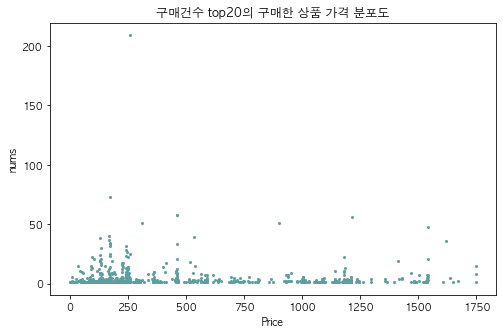

In [25]:
# 구매건수 top20의 구매한 상품들의 가격 분포 확인하기
plt.figure(figsize=(8, 5))
plt.scatter(top20_pur[top20_pur['event_type']=='purchase']['price'].value_counts().index, 
top20_pur[top20_pur['event_type']=='purchase']['price'].value_counts(), s = 4, color='#5F9EA0')
plt.xlabel('Price')
plt.ylabel('nums')
plt.title('구매건수 top20의 구매한 상품 가격 분포도');

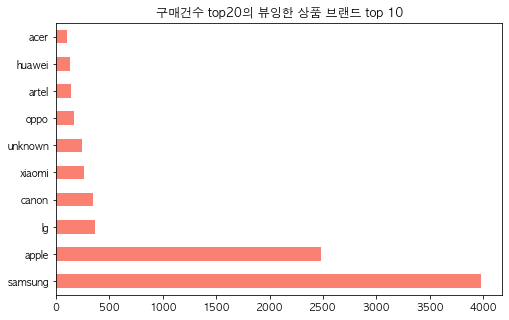

In [28]:
# 구매건수 top20의 뷰잉한 상품들의 브랜드 top 10 확인하기

# 위의 df에서 가장 많이 분포되어 있는 category code top 20은 어떤 것들인지 barh plot으로 나타내봄 = 주로 어떤 품목을 장바구니에 담는지 확인하기
pd.DataFrame(top20_pur[top20_pur['event_type']=='view'])['brand'].value_counts().nlargest(10).plot(kind='barh', figsize=(8,5), color='#FA8072')
plt.title('구매건수 top20의 뷰잉한 상품 브랜드 top 10');

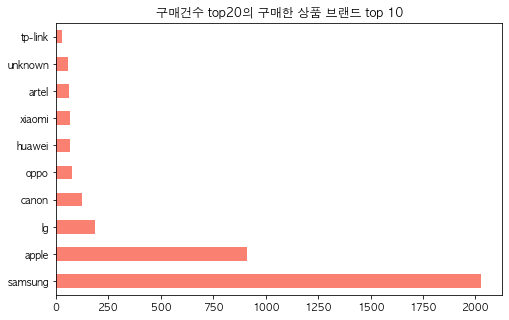

In [29]:
# 구매건수 top20의 구매한 상품들의 브랜드 top 20 확인하기

# 위의 df에서 가장 많이 분포되어 있는 category code top 10은 어떤 것들인지 barh plot으로 나타내봄 = 주로 어떤 품목을 장바구니에 담는지 확인하기
pd.DataFrame(top20_pur[top20_pur['event_type']=='purchase'])['brand'].value_counts().nlargest(10).plot(kind='barh', figsize=(8,5), color='#FA8072')
plt.title('구매건수 top20의 구매한 상품 브랜드 top 10');

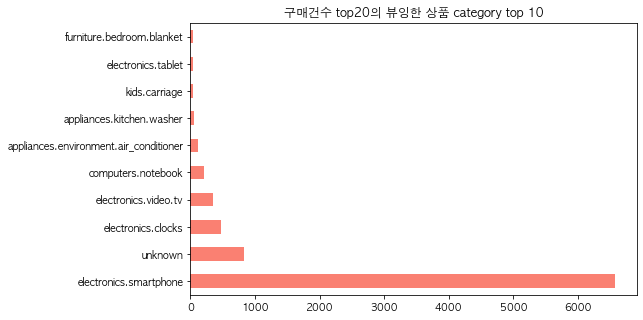

In [30]:
# 구매건수 top20의 뷰잉한 상품들의 category top 10 확인하기

# 위의 df에서 가장 많이 분포되어 있는 category code top 20은 어떤 것들인지 barh plot으로 나타내봄 = 주로 어떤 품목을 장바구니에 담는지 확인하기
pd.DataFrame(top20_pur[top20_pur['event_type']=='view'])['category_code'].value_counts().nlargest(10).plot(kind='barh', figsize=(8,5), color='#FA8072')
plt.title('구매건수 top20의 뷰잉한 상품 category top 10');

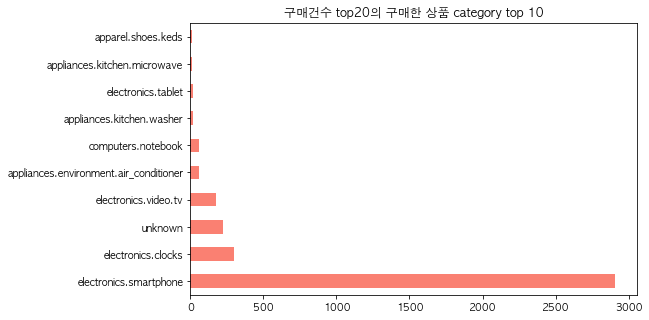

In [31]:
# 구매건수 top20의 구매한 상품들의 category top 20 확인하기

# 위의 df에서 가장 많이 분포되어 있는 category code top 20은 어떤 것들인지 barh plot으로 나타내봄 = 주로 어떤 품목을 장바구니에 담는지 확인하기
pd.DataFrame(top20_pur[top20_pur['event_type']=='purchase'])['category_code'].value_counts().nlargest(10).plot(kind='barh', figsize=(8,5), color='#FA8072')
plt.title('구매건수 top20의 구매한 상품 category top 10');

### 3. 구매전환율 top20 유저 분석

In [32]:
# 구매전환율 top20에 해당하는 고객들의 id
idlist1 = list(users_conv.nlargest(20, 'conversionrate').index)  # list에 할당하기  

# 전환율 top 20의 유저 정보 모으기
# 일단 id 별로 별도의 df로 추출
df01 = df_oct[df_oct['user_id'] == idlist1[0]]
df02 = df_oct[df_oct['user_id'] == idlist1[1]]
df03 = df_oct[df_oct['user_id'] == idlist1[2]]
df04 = df_oct[df_oct['user_id'] == idlist1[3]]
df05 = df_oct[df_oct['user_id'] == idlist1[4]]
df06 = df_oct[df_oct['user_id'] == idlist1[5]]
df07 = df_oct[df_oct['user_id'] == idlist1[6]]
df08 = df_oct[df_oct['user_id'] == idlist1[7]]
df09 = df_oct[df_oct['user_id'] == idlist1[8]]
df010 = df_oct[df_oct['user_id'] == idlist1[9]]
df011 = df_oct[df_oct['user_id'] == idlist1[10]]
df012 = df_oct[df_oct['user_id'] == idlist1[11]]
df013 = df_oct[df_oct['user_id'] == idlist1[12]]
df014 = df_oct[df_oct['user_id'] == idlist1[13]]
df015 = df_oct[df_oct['user_id'] == idlist1[14]]
df016 = df_oct[df_oct['user_id'] == idlist1[15]]
df017 = df_oct[df_oct['user_id'] == idlist1[16]]
df018 = df_oct[df_oct['user_id'] == idlist1[17]]
df019 = df_oct[df_oct['user_id'] == idlist1[18]]
df020 = df_oct[df_oct['user_id'] == idlist1[19]]

In [33]:
# 하나의 df로 병합하기
df0110 = pd.concat([df01, df02, df03, df04, df05, df06, df07, df08, df09, df010])
df01120 = pd.concat([df011, df012, df013, df014, df015, df016, df017, df018, df019, df020])

top20_df = pd.concat([df0110, df01120])
top20_df # 확인

event_time event_type  product_id  \
135571   2019-10-01 11:07:07       view     2701780   
135701   2019-10-01 11:07:16       view     2701589   
135959   2019-10-01 11:07:31       view     2701977   
136313   2019-10-01 11:07:51       view     2701731   
136525   2019-10-01 11:08:04       view     2701763   
...                      ...        ...         ...   
39074372 2019-10-29 13:26:16   purchase     1003304   
39074965 2019-10-29 13:26:46       view     1003304   
39075736 2019-10-29 13:27:26       cart     1003304   
39076253 2019-10-29 13:27:54   purchase     1003304   
39076866 2019-10-29 13:28:26       view     1003304   

                             category_code    brand        price    user_id  \
135571    appliances.kitchen.refrigerators  samsung  1137.739990  513322839   
135701    appliances.kitchen.refrigerators  samsung  1002.320007  513322839   
135959    appliances.kitchen.refrigerators  samsung   771.960022  513322839   
136313    appliances.kitchen.refrigerators       lg   959.729980  513322839   
136525    appliances.kitchen.refrigerators       lg   889.080017  513322839   
...                                    ...      ...          ...        ...   
39074372            electronics.smartphone    apple   591.780029  518524843   
39074965            electronics.smartphone    apple   591.780029  518524843   
39075736            electronics.smartphone    apple   591.780029  518524843   
39076253            electronics.smartphone    apple   591.780029  518524843   
39076866            electronics.smartphone    apple   591.780029  518524843   

                                  user_session event_date  event_month  \
135571    0eedef43-b496-46a8-a027-70bdb0c1ed22 2019-10-01           10   
135701    0eedef43-b496-46a8-a027-70bdb0c1ed22 2019-10-01           10   
135959    0eedef43-b496-46a8-a027-70bdb0c1ed22 2019-10-01           10   
136313    0eedef43-b496-46a8-a027-70bdb0c1ed22 2019-10-01           10   
136525    0eedef43-b496-46a8-a027-70bdb0c1ed22 2019-10-01           10   
...                                        ...        ...          ...   
39074372  9ad9f460-42a6-4afb-a1ec-6a740cbb4a18 2019-10-29           10   
39074965  9ad9f460-42a6-4afb-a1ec-6a740cbb4a18 2019-10-29           10   
39075736  9ad9f460-42a6-4afb-a1ec-6a740cbb4a18 2019-10-29           10   
39076253  9ad9f460-42a6-4afb-a1ec-6a740cbb4a18 2019-10-29           10   
39076866  9ad9f460-42a6-4afb-a1ec-6a740cbb4a18 2019-10-29           10   

          event_day day_of_week  event_hour  event_week  
135571            1     Tuesday          11          40  
135701            1     Tuesday          11          40  
135959            1     Tuesday          11          40  
136313            1     Tuesday          11          40  
136525            1     Tuesday          11          40  
...             ...         ...         ...         ...  
39074372         29     Tuesday          13          44  
39074965         29     Tuesday          13          44  
39075736         29     Tuesday          13          44  
39076253         29     Tuesday          13          44  
39076866         29     Tuesday          13          44  

[1399 rows x 14 columns]

#### 1) 전환율 top 20 유저의 구매 시간 분석

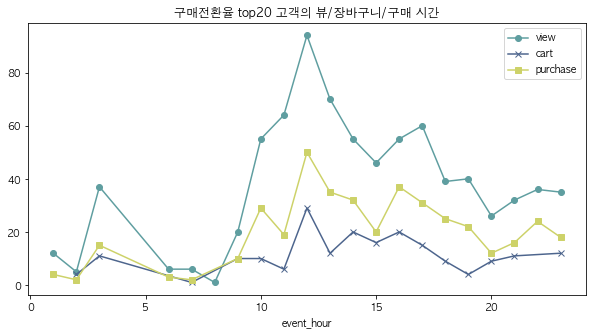

In [34]:
# 구매건수 top20의 방문 시간 확인하기
top20_df[top20_df['event_type'] == 'view'].groupby(['event_hour']).user_id.count().plot(kind='line', marker = 'o', figsize=(10,5), color = '#5F9EA0')
top20_df[top20_df['event_type'] == 'cart'].groupby(['event_hour']).user_id.count().plot(kind='line', marker = 'x', figsize=(10,5), color = '#4D658D')
top20_df[top20_df['event_type'] == 'purchase'].groupby(['event_hour']).user_id.count().plot(kind='line', marker = 's', figsize=(10,5), color = '#CDD269')
plt.legend(['view','cart','purchase'])

plt.title('구매전환율 top20 고객의 뷰/장바구니/구매 시간');

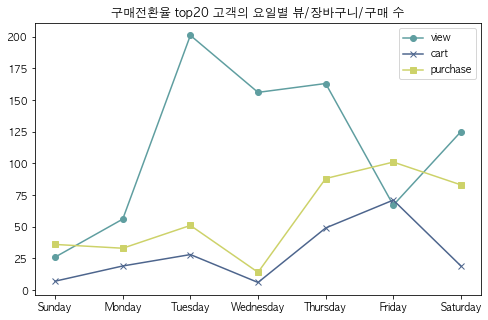

In [35]:
# top20의 요일별 방문 수 확인하기
top20cv = pd.DataFrame(top20_df[top20_df['event_type'] == 'view'].groupby(['day_of_week']).user_id.count())
top20cc = pd.DataFrame(top20_df[top20_df['event_type'] == 'cart'].groupby(['day_of_week']).user_id.count())
top20cp = pd.DataFrame(top20_df[top20_df['event_type'] == 'purchase'].groupby(['day_of_week']).user_id.count())

weekday_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
top20cv = top20cv.loc[weekday_order]        # 일~토 순으로 요일 재정렬

xv1 = top20cv.index
yv1 = top20cv['user_id']
yv2 = top20cc['user_id']
yv3 = top20cp['user_id']

plt.plot(xv1, yv1, marker = 'o', color = '#5F9EA0')
plt.plot(xv1, yv2, marker = 'x', color = '#4D658D')
plt.plot(xv1, yv3, marker = 's', color = '#CDD269')
plt.legend(['view','cart','purchase'])

plt.title('구매전환율 top20 고객의 요일별 뷰/장바구니/구매 수');

#### 2) 전환율 top 20 유저의 구매 품목 분석

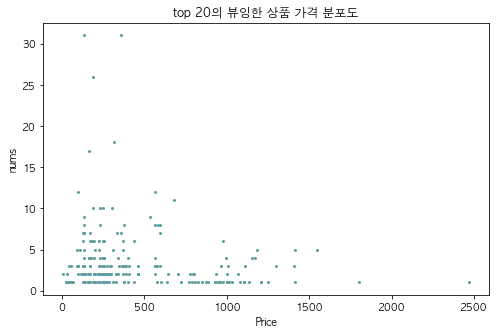

In [36]:
# top 10의 뷰잉한 상품들의 가격 분포 확인하기
plt.figure(figsize=(8, 5))
plt.scatter(top20_df[top20_df['event_type']=='view']['price'].value_counts().index, 
top20_df[top20_df['event_type']=='view']['price'].value_counts(), s = 4, color='#5F9EA0')
plt.xlabel('Price')
plt.ylabel('nums')
plt.title('top 20의 뷰잉한 상품 가격 분포도');

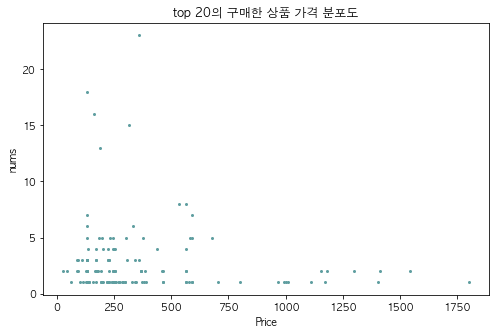

In [37]:
# top 20의의 구매한 상품들의 가격 분포 확인하기
plt.figure(figsize=(8, 5))
plt.scatter(top20_df[top20_df['event_type']=='purchase']['price'].value_counts().index, 
top20_df[top20_df['event_type']=='purchase']['price'].value_counts(), s = 4, color='#5F9EA0')
plt.xlabel('Price')
plt.ylabel('nums')
plt.title('top 20의 구매한 상품 가격 분포도');

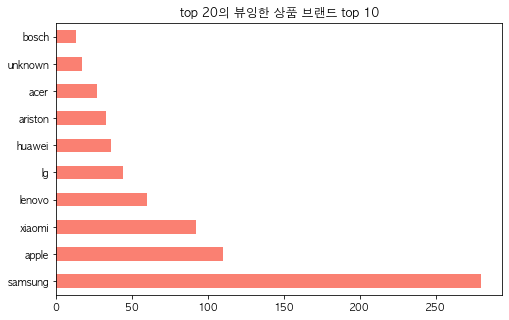

In [38]:
# top 20의의 뷰잉한 상품들의 브랜드 top 10 확인하기

# 위의 df에서 가장 많이 분포되어 있는 category code top 20은 어떤 것들인지 barh plot으로 나타내봄 = 주로 어떤 품목을 장바구니에 담는지 확인하기
pd.DataFrame(top20_df[top20_df['event_type']=='view'])['brand'].value_counts().nlargest(10).plot(kind='barh', figsize=(8,5), color='#FA8072')
plt.title('top 20의 뷰잉한 상품 브랜드 top 10');

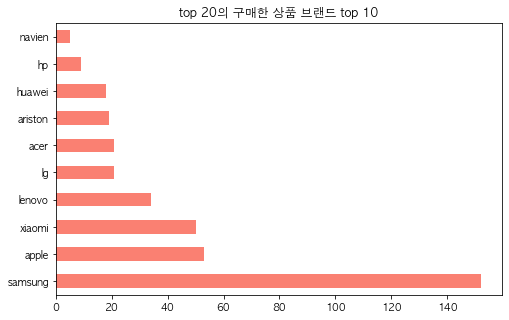

In [39]:
# top 20의의 구매한 상품들의 브랜드 top 10 확인하기

# 위의 df에서 가장 많이 분포되어 있는 category code top 10은 어떤 것들인지 barh plot으로 나타내봄 = 주로 어떤 품목을 장바구니에 담는지 확인하기
pd.DataFrame(top20_df[top20_df['event_type']=='purchase'])['brand'].value_counts().nlargest(10).plot(kind='barh', figsize=(8,5), color='#FA8072')
plt.title('top 20의 구매한 상품 브랜드 top 10');

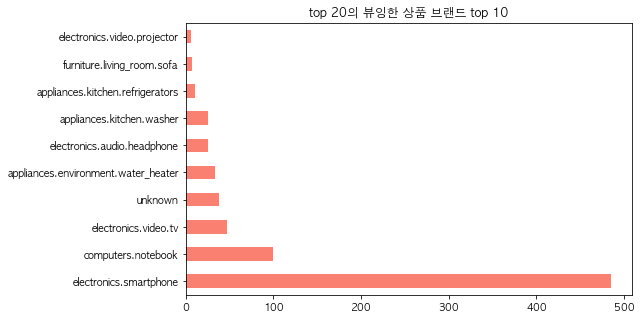

In [40]:
# top20의 뷰잉한 상품들의 category top 10 확인하기

# 위의 df에서 가장 많이 분포되어 있는 category code top 20은 어떤 것들인지 barh plot으로 나타내봄 = 주로 어떤 품목을 장바구니에 담는지 확인하기
pd.DataFrame(top20_df[top20_df['event_type']=='view'])['category_code'].value_counts().nlargest(10).plot(kind='barh', figsize=(8,5), color='#FA8072')
plt.title('top 20의 뷰잉한 상품 브랜드 top 10');

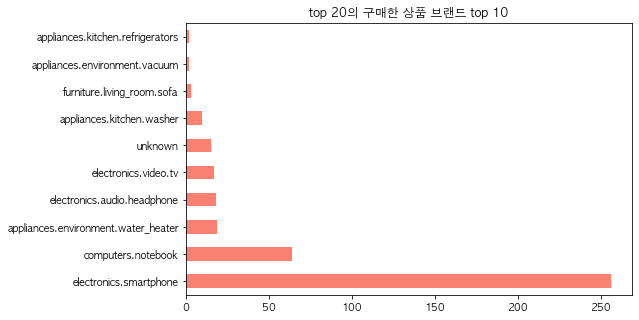

In [41]:
# top20의 구매한 상품들의 브랜드 top 10 확인하기

# 위의 df에서 가장 많이 분포되어 있는 category code top 20은 어떤 것들인지 barh plot으로 나타내봄 = 주로 어떤 품목을 장바구니에 담는지 확인하기
pd.DataFrame(top20_df[top20_df['event_type']=='purchase'])['category_code'].value_counts().nlargest(10).plot(kind='barh', figsize=(8,5), color='#FA8072')
plt.title('top 20의 구매한 상품 브랜드 top 10');

-------------
### 🔥 저관여제품
- 제품의 중요도가 낮고 가격이 저렴하며 상표 간의 차이가 별로 없을 뿐만 아니라 잘못 구매해도 상관없다고 생각하여 소비자가 별다른 고민 없이 구매하는 제품
https://ko.dict.naver.com/#/entry/koko/faedcbc19b9449ae9d8351a4aafcbec6

    - 저관여제품 중 **필수재이면서 소비기간이 짧은 제품**에 대한 수요를 증대시킨다면 이는 유저들의 지속적인 재구매를 유도할 수 있을 것
    - 저관여 소비자 행동 특징: https://4ir.kisti.re.kr/ick/cmmn/viewPost/20180207000009, http://m.blog.naver.com/sudream2003/220219583872
    
        - 소수의 상표와 제한된 제품 속성에 대해서만 정보를 탐색한다.
        - 태도변화가 쉽게 일어나고 변화된 태도 또한 잠정적이다.
        - 광고의 반복적 노출은 소비자의 태도와 행동 변화에 효과가 있다.
        - 상표 선호에 위해서가 아니라 습관적으로 동일 상품을 구매하는 경향이 있다.
    
    - 따라서 저관여제품 광고 반복 노출을 통해 소비자의 행동 변화, 즉 구매 전환을 유도하기
    - 가격 할인 제공

- 생필품의 경우 구매 주기가 짧아 반복적인 재구매 발생: 
    - https://corp.tmon.co.kr/media/detail/15277
        
        - 생수의 경우 재구매 주기가 약 `한 달`
        - 기저귀의 경우 약 `2주`

    - http://www.openads.co.kr/content/contentDetail?contsId=4386

        - 식품/음료: `5~14일 이내`
        - 건강보조식품, 뷰티, 패션잡화: `1~3개월 이내`
        - 생활용품: `3개월 이상`
        - 여성 의류: `당일~1일 이내`  +  비교적 특정 주기에 편중되지 않고 다양한 주기로 구매하는 이용자들이 고루 있음

        --------
- 데이터셋에서 저관여제품에 해당하는 카테고리

    - apparel.sock 
    - apparel.underwear
    - apparel.tshirt                            
    - kids.fmcg.diapers                         
    - kids.toys                                
    - stationery.cartrige                      

In [21]:
# 위 제품군의 재구매 텀 구하기
list_c = ['apparel.sock', 'apparel.underwear', 'apparel.tshirt', 'kids.fmcg.diapers', 'kids.toys', 'stationery.cartrige']

df_purchase.groupby('category_code')

In [22]:
# 위 제품군에 대한 구매전환율 구하기
dict_conv = {}               # 구매전환율 할당하여 저장할 딕셔너리 생성

# 반복문으로 구매전환율 구해서 딕셔너리에 할당
for c in list_c:
    cdf = df_oct[df_oct['category_code']==c]
    dict_conv[c] = cdf[cdf['event_type']=='purchase'].event_type.count() / cdf[cdf['event_type']=='view'].user_session.nunique()

dict_conv

{'apparel.sock': 0.015779092702169626,
 'apparel.underwear': 0.005389673385792821,
 'apparel.tshirt': 0.005120867535205964,
 'kids.fmcg.diapers': 0.06809289935902772,
 'kids.toys': 0.023569718484273094,
 'stationery.cartrige': 0.04798464491362764}

In [23]:
# 앞서 구한 카테고리별 구매 전환율의 평균값 구해보기
cate_conv = df_purchase.groupby('category_code').event_type.count() / df_view.groupby('category_code').user_session.nunique()
cate_conv.mean()

0.031665112392159675

- 대체로 상품별 구매 전환율 평균값보다 앞서 선정한 상품군의 구매전환율이 더 낮음